In [1]:
%matplotlib inline

In [2]:
#import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
#from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc

from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr
import seaborn as sns


## Read the SLP Scores 

In [3]:
### LINUX BOX PATH
#path = r'/home/deniz/Code/ClinicalScoreProject/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'


# ALS DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'
df_als = pd.read_csv(path)

df_als = df_als.drop('Unnamed: 8', axis=1)

#print(df_als.shape)
#print(df_als.columns)
#print(df_als['Subject ID'].unique())
#df_als.head()

# STROKE DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Stroke/SLP_Assessment_PS.csv'
df_ps = pd.read_csv(path)

df_ps = df_ps.drop('Unnamed: 8', axis=1)

#print(df_ps.shape)
#print(df_ps.columns)
#print(df_ps['Subject ID'].unique())
#df_ps.head()

# HEALTHY CONTROL DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Healthy controls/SLP_Assessment_HC.csv'
df_hc = pd.read_csv(path)

df_hc = df_hc.drop('Unnamed: 8', axis=1)
df_hc = df_hc.drop('Unnamed: 15', axis=1)
#print(df_hc.shape)
#print(df_hc.columns)
#print(df_hc['Subject ID'].unique())



slp_scores = pd.concat([df_als, df_ps, df_hc], ignore_index=True)
# average of the clinical scores 

slp_scores['Tot_avg'] = slp_scores.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
slp_scores['Symmetry_avg'] = slp_scores.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
slp_scores['ROM_avg'] = slp_scores.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
slp_scores['Speed_avg'] = slp_scores.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
slp_scores['Variability_avg'] = slp_scores.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
slp_scores['Fatigue_avg'] = slp_scores.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)


tasks = ['BBP_NORMAL',  'PATAKA', 'PA','BLOW', 'KISS','NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE' ,'BROW']

ids = ['A', 'O', 'S', 'N']

def task_labeler(row):
    for t in tasks: 
        if t in row: 
            return t
        
def pop_labeler(row):
    for i in ids:
        if i in row:
            if i == "A":
                return 'ALS'
            elif i == 'O' or i == "S":
                return 'Stroke'
            else:
                return 'HC'
            
            
def hc_label_change(sub_id):
    s = sub_id
    if 'N' in sub_id: 
        
        s = s.replace('N0', 'NF')

    return s
    

slp_scores['task'] = [task_labeler(x) for x in slp_scores['File Name']]
slp_scores['population'] = [pop_labeler(x) for x in slp_scores['Subject ID']]
slp_scores['Subject ID'] = [hc_label_change(x) for x in slp_scores['Subject ID']]


slp_scores = slp_scores.loc[(slp_scores['task'] == 'BBP_NORMAL') | (slp_scores['task'] == 'NSM_OPEN')| 
                              (slp_scores['task'] == 'NSM_SPREAD') | (slp_scores['task'] == 'NSM_BIGSMILE')]

print(slp_scores.shape)
print(slp_scores.columns)
print()
print('Total numbr of participants are: ',len(slp_scores['Subject ID'].unique()))
print()
print(slp_scores['Subject ID'].unique())
print()
print('Subject IDs included are: ',slp_scores['Subject ID'].unique())
print()
print(slp_scores.columns)
print()
print('The tasks are: ', slp_scores['task'].unique())

slp_scores.head()






(116, 22)
Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'task', 'population'],
      dtype='object')

Total numbr of participants are:  36

['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S011' 'S012' 'S013' 'NF01' 'NF02' 'NF03' 'NF04' 'NF07'
 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19']

Subject IDs included are:  ['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S011' 'S012' 'S013' 'NF01' 'NF02' 'NF03' 'NF04' 'NF07'
 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19']

Index(['Fi

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task,population
0,A002_02_BBP_NORMAL_color.avi,A002,1,1,1,1,1,5,2,1,...,1,6,5.5,1.5,1.0,1.0,1.0,1.0,BBP_NORMAL,ALS
5,A002_02_NSM_OPEN_color.avi,A002,1,1,1,1,1,5,1,1,...,1,5,5.0,1.0,1.0,1.0,1.0,1.0,NSM_OPEN,ALS
6,A002_02_NSM_SPREAD_color.avi,A002,2,1,1,1,1,6,2,2,...,2,9,7.5,2.0,1.5,1.0,1.5,1.5,NSM_SPREAD,ALS
7,A006_02_BBP_NORMAL_color.avi,A006,2,1,1,1,1,6,2,1,...,1,6,6.0,2.0,1.0,1.0,1.0,1.0,BBP_NORMAL,ALS
12,A006_02_NSM_OPEN_color.avi,A006,1,1,1,1,3,7,2,1,...,2,7,7.0,1.5,1.0,1.0,1.0,2.5,NSM_OPEN,ALS


In [25]:
#slp_scores.loc[(slp_scores['Symmetry_avg'] == 1)]
# NF11 NF7 NF8

#slp_scores.loc[(slp_scores['Symmetry_avg'] == 2)|(slp_scores['Symmetry_avg'] == 2.5)]
# A6 A9 S3 S7 S8

#slp_scores.loc[(slp_scores['Symmetry_avg'] == 3)|(slp_scores['Symmetry_avg'] == 3.5)]
# S2 S9 S11 S12

#slp_scores.loc[(slp_scores['Symmetry_avg'] == 3.5)]

slp_scores.loc[(slp_scores['Symmetry_avg'] >= 4)]
# S11 S9 S5

## S1, S2, S3, S5, S6, S9 and S11 have high Symmetry scores for NSM_Spread 
## A006 and A009 
### Diego doesn't have S11, so we are going to look at S9
### S9 is RSSDK format 


#slp_scores.loc[(slp_scores['Symmetry_avg'] == 1) & (slp_scores['task'] == 'NSM_SPREAD')]

### NF8, NF7, NF11

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task,population
121,S005_02_BBP_NORMAL_color.avi,S005,4,3,2,2,2,13,4,3,...,2,12,12.5,4.0,3.0,1.5,2.0,2.0,BBP_NORMAL,Stroke
127,S005_02_NSM_SPREAD_color.avi,S005,4,3,2,1,1,11,4,4,...,1,12,11.5,4.0,3.5,2.0,1.0,1.0,NSM_SPREAD,Stroke
134,S006_02_NSM_SPREAD_color.avi,S006,3,5,4,2,1,15,5,5,...,1,18,16.5,4.0,5.0,4.0,2.5,1.0,NSM_SPREAD,Stroke
156,S009_02_NSM_SPREAD_color.avi,S009,4,2,2,3,2,13,4,4,...,3,15,14.0,4.0,3.0,2.0,2.5,2.5,NSM_SPREAD,Stroke
157,S011_02_BBP_NORMAL_color.avi,S011,4,2,1,1,1,9,4,3,...,2,12,10.5,4.0,2.5,1.0,1.5,1.5,BBP_NORMAL,Stroke
164,S011_02_NSM_SPREAD_color.avi,S011,4,2,1,4,2,13,4,3,...,4,15,14.0,4.0,2.5,1.0,3.5,3.0,NSM_SPREAD,Stroke


In [51]:
slp_scores['population'].unique()

array(['ALS', 'Stroke', 'HC'], dtype=object)

In [26]:
slp_scores[slp_scores['Subject ID'] == 'S005']

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task,population
121,S005_02_BBP_NORMAL_color.avi,S005,4,3,2,2,2,13,4,3,...,2,12,12.5,4.0,3.0,1.5,2.0,2.0,BBP_NORMAL,Stroke
126,S005_02_NSM_OPEN_color.avi,S005,3,2,1,1,1,8,2,1,...,1,6,7.0,2.5,1.5,1.0,1.0,1.0,NSM_OPEN,Stroke
127,S005_02_NSM_SPREAD_color.avi,S005,4,3,2,1,1,11,4,4,...,1,12,11.5,4.0,3.5,2.0,1.0,1.0,NSM_SPREAD,Stroke


In [6]:
neuroface_subjects = slp_scores['Subject ID'].unique()
neuroface_subjects

array(['A002', 'A006', 'A008', 'A009', 'A010', 'A011', 'A012', 'A014',
       'A015', 'A016', 'A017', 'OP01', 'OP02', 'OP03', 'S001', 'S002',
       'S003', 'S005', 'S006', 'S007', 'S008', 'S009', 'S011', 'S012',
       'S013', 'NF01', 'NF02', 'NF03', 'NF04', 'NF07', 'NF08', 'NF10',
       'NF11', 'NF12', 'NF17', 'NF19'], dtype=object)

# Fine-Tuned All Features All Common Subjects 

### Non-standardized 

In [14]:

# read stroke data 

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
#task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE

features = ['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL','W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',  
            'R_LCRC', 'D_1', 'D_2', 'D_3', 'LL_PATH', 'A_RANGE', 'A_ABS_DIFF', 'A_CCC',
            'R_SYMM', 'E_MEAN', 'E_RANGE']

repeated_features = ['D_0','WIDTH_MAX','WIDTH_MEAN', 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN','HEIGHT_MAX', 'HEIGHT_MIN', 
                     'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN','A_MOUTH','A_MEAN']
print(len(features))


stroke_df = pd.DataFrame()

for task in range(len(tasks)):
    
    stroke_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/stroke/metric_output_"+tasks[task]+".csv"    
    df = pd.read_csv(stroke_file)
    df = df.drop('Unnamed: 0', axis=1)
    stroke_df = pd.concat([stroke_df, df], ignore_index=True)
        
print(stroke_df.shape)
print(stroke_df.subject_id.unique())


# read als
als_df = pd.DataFrame()

for task in range(len(tasks)):

    als_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/als/metric_output_"+tasks[task]+".csv"
    df = pd.read_csv(als_file)
    df = df.drop('Unnamed: 0', axis=1)
    als_df = pd.concat([als_df, df], ignore_index=True)

print(als_df.shape)
print(als_df.subject_id.unique())

# merge the two feature dfs into one feature df
feature_df = pd.concat([stroke_df, als_df], ignore_index=True)

feature_df = feature_df.drop(repeated_features, axis=1)

print(feature_df.shape)
feature_df.head()

19
(1034, 34)
['NF11' 'NF12' 'NF13' 'NF14' 'NF15' 'NF16' 'NF17' 'NF18' 'NF19' 'NF20'
 'NF21' 'NF22' 'NF24' 'NF26' 'NF27' 'NF00' 'NF02' 'NF03' 'NF04' 'NF05'
 'NF06' 'NF07' 'NF08' 'NF09' 'NF10' 'OP01' 'OP02' 'OP03' 'OP05' 'OP06'
 'OP07' 'OP08' 'OP09' 'OP10' 'OP12' 'S001' 'S002' 'S003' 'S005' 'S006'
 'S007' 'S008' 'S009' 'S010' 'S013' 'NF01']
(269, 34)
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'A005' 'A007' 'A013' 'A014'
 'A016' 'A017' 'AF18' 'NF01']
(1303, 23)


,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,...,D_1,D_2,D_3,LL_PATH,A_RANGE,A_ABS_DIFF,A_CCC,R_SYMM,E_MEAN,E_RANGE
0,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.594900,-0.544603,1.077094,0.876171,...,1.049206,0.568557,1.173047,158.902339,0.903907,0.903907,0.903907,0.215262,0.883412,0.173549
1,NF11,BBP_NORMAL,0,2,2.188607,0.996711,0.820745,-0.436266,1.044838,0.870372,...,0.899794,0.533262,1.128183,110.942027,0.893452,0.893452,0.893452,0.091104,0.883224,0.161749
2,NF11,BBP_NORMAL,0,3,2.058023,1.047133,0.769061,-0.903222,1.022509,0.865620,...,0.993397,0.818813,1.007924,117.297017,0.917317,0.917317,0.917317,0.367979,0.880140,0.149042
3,NF11,BBP_NORMAL,0,4,2.075979,1.042164,1.059445,-0.647830,1.027606,0.885372,...,0.902072,0.835538,1.109912,112.839959,0.837290,0.837290,0.837290,0.170831,0.878176,0.144935
4,NF11,BBP_NORMAL,0,5,1.981968,1.005337,0.676766,-0.322046,1.134544,0.922301,...,1.729688,0.614693,0.953813,92.115035,0.687558,0.687558,0.687558,0.445453,0.905869,0.126557


In [15]:
# what is the common ids betweeen neuroface and this dataset
print(np.intersect1d(feature_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(feature_df.subject_id.unique(),neuroface_subjects)))

# merge the feature df with neuroface clinical scores

sub_neuro_df = feature_df.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

#sub_neuro_df = 
print(len(sub_neuro_df.subject_id.unique()))
print(len(feature_df.subject_id.unique()))
print(sub_neuro_df.task.unique())
print()
print(slp_scores.shape)
print(feature_df.shape)
print(sub_neuro_df.shape)
print(sub_neuro_df.columns)
sub_neuro_df = sub_neuro_df.drop(['type','File Name',
       'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)', 'Speed (SLP1)',
       'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)', 'Symmetry (SLP2)',
       'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)', 'Fatigue (SLP2)',
       'Tot (SLP2)' ], axis=1)


# filtering out the outliers 

#z_scores = stats.zscore(sub_neuro_df[features])
#abs_z_scores = np.abs(z_scores)
#filtered_entries = (abs_z_scores < 3).all(axis=1)
#sub_neuro_df = sub_neuro_df[filtered_entries]

#print(sub_neuro_df.shape)

['A008' 'A009' 'A010' 'A011' 'A014' 'A016' 'A017' 'NF01' 'NF02' 'NF03'
 'NF04' 'NF07' 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19' 'OP01' 'OP02'
 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008' 'S009' 'S013']
30
30
59
['BBP_NORMAL' 'NSM_OPEN' 'NSM_SPREAD' 'NSM_BIGSMILE']

(116, 22)
(1303, 23)
(643, 44)
Index(['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'R_LCRC',
       'D_1', 'D_2', 'D_3', 'LL_PATH', 'A_RANGE', 'A_ABS_DIFF', 'A_CCC',
       'R_SYMM', 'E_MEAN', 'E_RANGE', 'File Name', 'Subject ID',
       'Symmetry (SLP1)', 'ROM (SLP1)', 'Speed (SLP1)', 'Variability (SLP1)',
       'Fatigue (SLP1)', 'Tot (SLP1)', 'Symmetry (SLP2)', 'ROM (SLP2)',
       'Speed (SLP2)', 'Variability (SLP2)', 'Fatigue (SLP2)', 'Tot (SLP2)',
       'Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg', 'Variability_avg',
       'Fatigue_avg', 'population'],
      dtype='object')


In [16]:
criteria = ((sub_neuro_df['subject_id'] == 'NF08') |(sub_neuro_df['subject_id'] == 'NF11')|
            (sub_neuro_df['subject_id'] == 'A002') |(sub_neuro_df['subject_id'] == 'A006')|
            (sub_neuro_df['subject_id'] == 'A009') | (sub_neuro_df['subject_id'] == 'S003')|
            (sub_neuro_df['subject_id'] == 'S005') | (sub_neuro_df['subject_id'] == 'S007')|
            (sub_neuro_df['subject_id'] == 'S008')|(sub_neuro_df['subject_id'] == 'S002')|
            (sub_neuro_df['subject_id'] == 'S009')|(sub_neuro_df['subject_id'] == 'NF07'))

#face_valid = sub_neuro_df.loc[criteria]

face_valid = sub_neuro_df

In [17]:
face_valid.task.unique()

array(['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE'],
      dtype=object)

### Symmetry Validation 

In [ ]:
#face_valid = sub_neuro_df.loc[(sub_neuro_df['subject_id'] == 'NF08') | (sub_neuro_df['subject_id'] == 'A009')| 
#                              (sub_neuro_df['subject_id'] == 'S006') | (sub_neuro_df['subject_id'] == 'S009')]


#face_valid = sub_neuro_df.loc[(sub_neuro_df['subject_id'] == 'NF11') | (sub_neuro_df['subject_id'] == 'A009')| 
#                              (sub_neuro_df['subject_id'] == 'S006') | (sub_neuro_df['subject_id'] == 'S009')]


In [55]:
fv_symmetry = face_valid.loc[ (face_valid['task'] == 'NSM_SPREAD')|(face_valid['task'] == 'BBP_NORMAL')]
                           #   |(face_valid['task'] == 'NSM_BIGSMILE')|(face_valid['task'] == 'NSM_OPEN')]
                              

sym_c = ((face_valid['subject_id'] == 'NF08') |(face_valid['subject_id'] == 'NF11')|
            (face_valid['subject_id'] == 'A002') |(face_valid['subject_id'] == 'A006')|
            (face_valid['subject_id'] == 'A009') | (face_valid['subject_id'] == 'S003')|
            (face_valid['subject_id'] == 'S005') | 
            (face_valid['subject_id'] == 'S008')|(face_valid['subject_id'] == 'S002')|
            (face_valid['subject_id'] == 'S009'))        

#fv_symmetry = face_valid.loc[sym_c]

#fv_symmetry = face_valid.loc[(face_valid['population'] == 'Stroke') |(face_valid['population'] == 'ALS')] 

fv_symmetry = fv_symmetry.loc[ (fv_symmetry['task'] == 'NSM_SPREAD')|(face_valid['task'] == 'BBP_NORMAL')]

fv_symmetry = fv_symmetry.drop(['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL',
       'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'LL_PATH', 'D_2' ], axis=1)


# filtering out the outliers 

features  = [ 'R_LCRC', 'D_1', 'D_3', 'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'R_SYMM', 'E_MEAN', 'E_RANGE']

z_scores = stats.zscore(fv_symmetry[features])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
fv_symmetry = fv_symmetry[filtered_entries]


In [82]:
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'OP03']
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'OP01']
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'OP02']
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'S013']
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'S007']
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'S001']
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'S002']
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'S008']
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'A008']
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'A014']
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'A016']
fv_symmetry = fv_symmetry[fv_symmetry.subject_id != 'A017']


In [56]:
fv_symmetry['task'].replace({'BBP_NORMAL':'BBP', 'NSM_BIGSMILE': 'BIG SMILE',
                            'NSM_SPREAD':'SPREAD','NSM_OPEN': 'OPEN'}, inplace=True)

fv_symmetry.rename(columns={'Symmetry_avg':'Symmetry Clinical Score'}, inplace=True)

Spearmans correlation between D_1 and Symmetry Clinical Score for task BBP: 0.126
p_value: 0.037706005

Spearmans correlation between D_3 and Symmetry Clinical Score for task BBP: 0.099
p_value: 0.101485916

Spearmans correlation between R_LCRC and Symmetry Clinical Score for task BBP: -0.019
p_value: 0.749448754

Spearmans correlation between A_RANGE and Symmetry Clinical Score for task BBP: -0.245
p_value: 0.000042075

Spearmans correlation between A_ABS_DIFF and Symmetry Clinical Score for task BBP: -0.245
p_value: 0.000042075

Spearmans correlation between A_CCC and Symmetry Clinical Score for task BBP: -0.245
p_value: 0.000042075

Spearmans correlation between R_SYMM and Symmetry Clinical Score for task BBP: -0.019
p_value: 0.749448754

Spearmans correlation between E_MEAN and Symmetry Clinical Score for task BBP: 0.058
p_value: 0.338857794

Spearmans correlation between E_RANGE and Symmetry Clinical Score for task BBP: 0.054
p_value: 0.369181085

Spearmans correlation between D_1

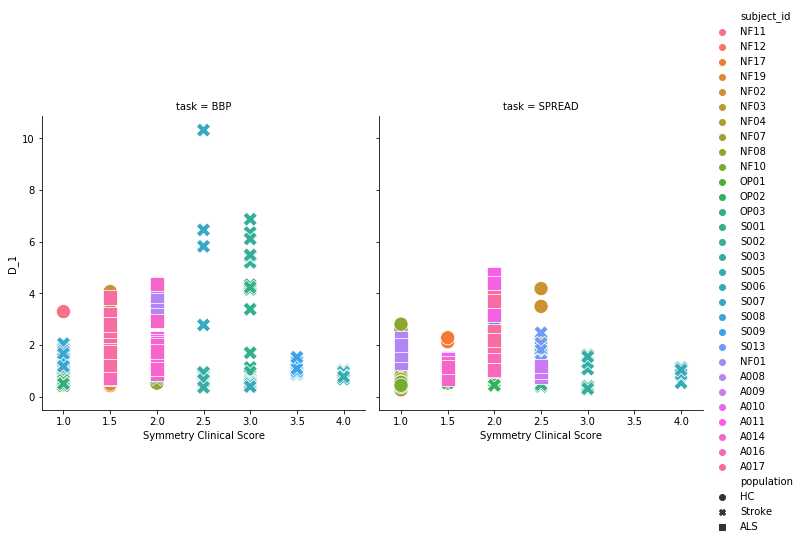

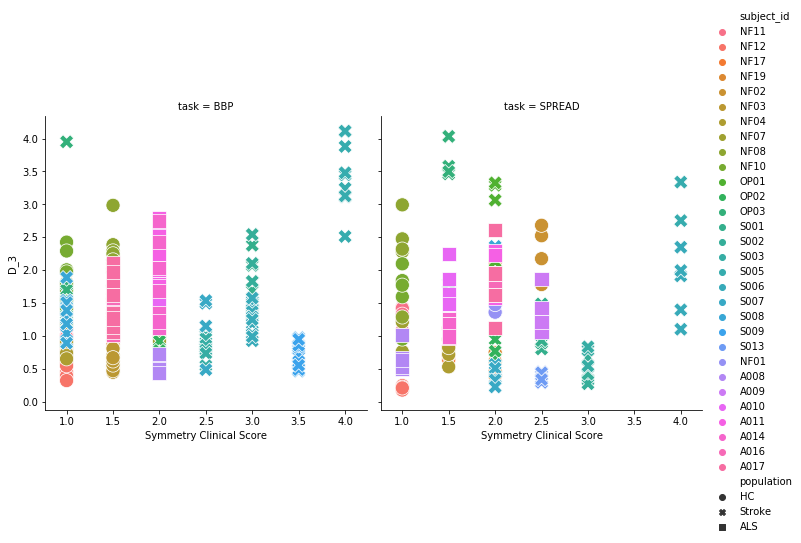

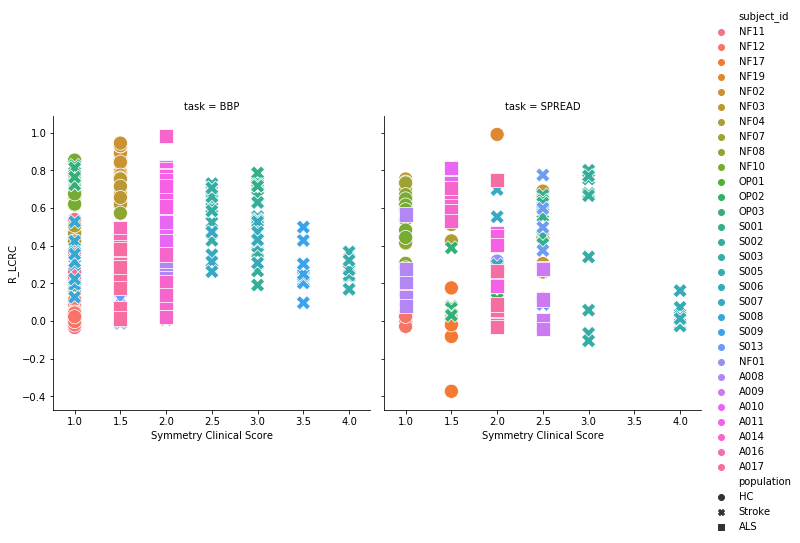

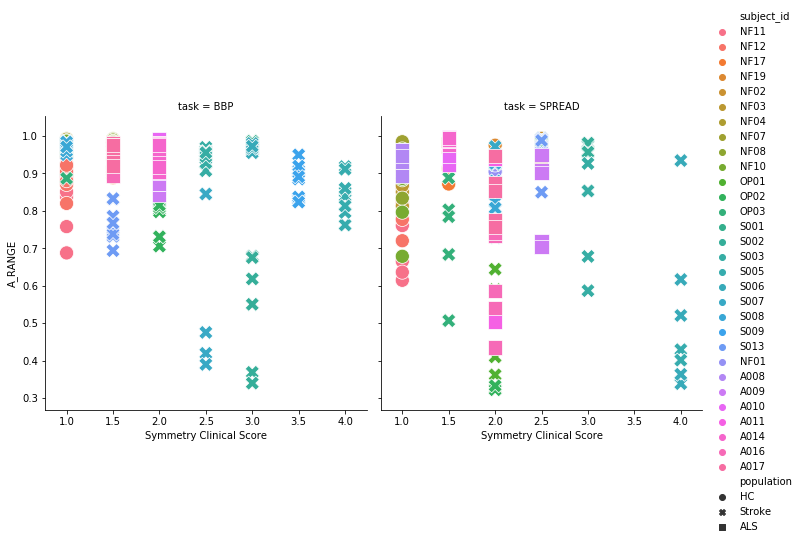

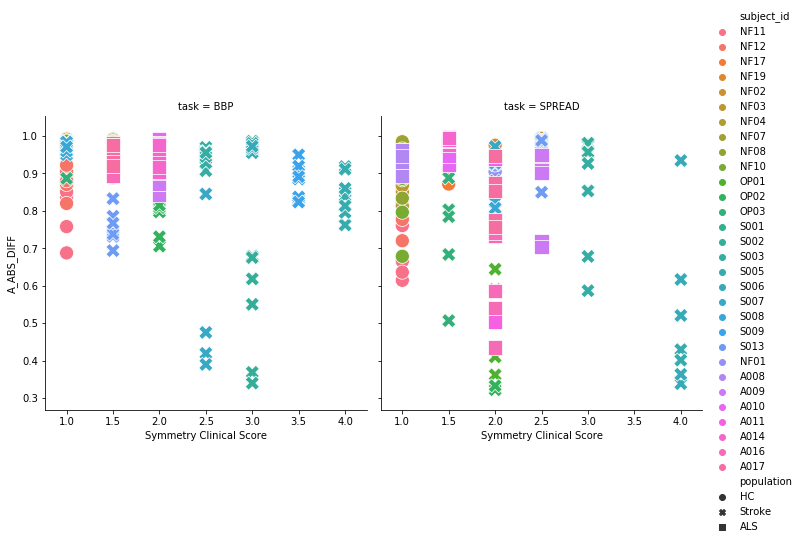

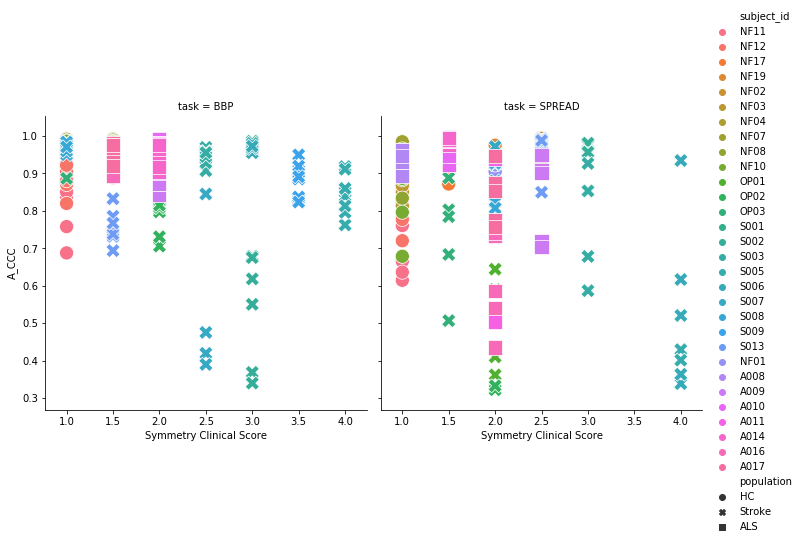

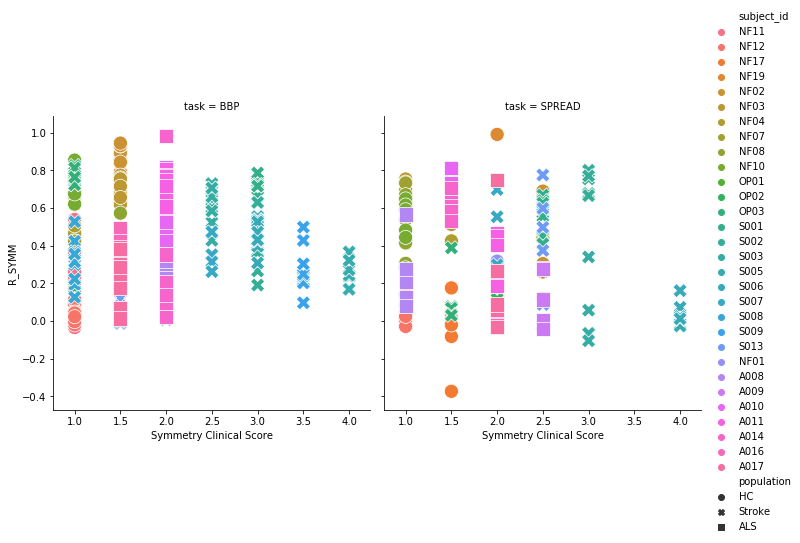

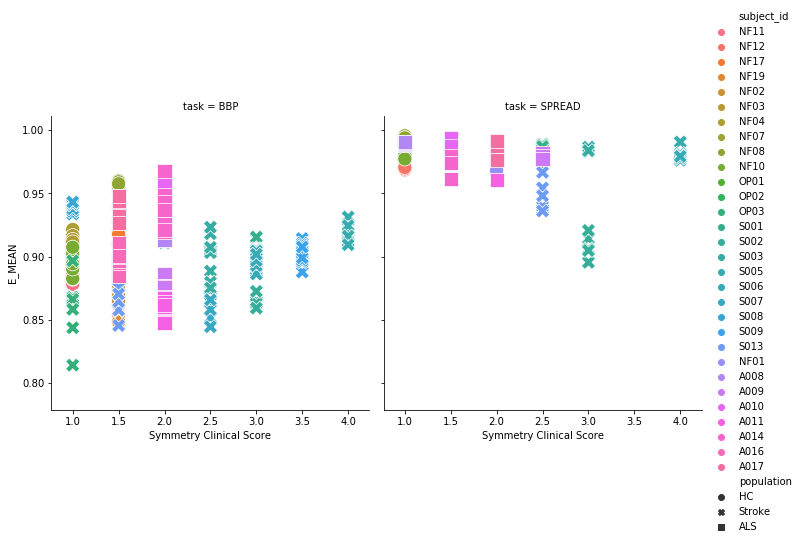

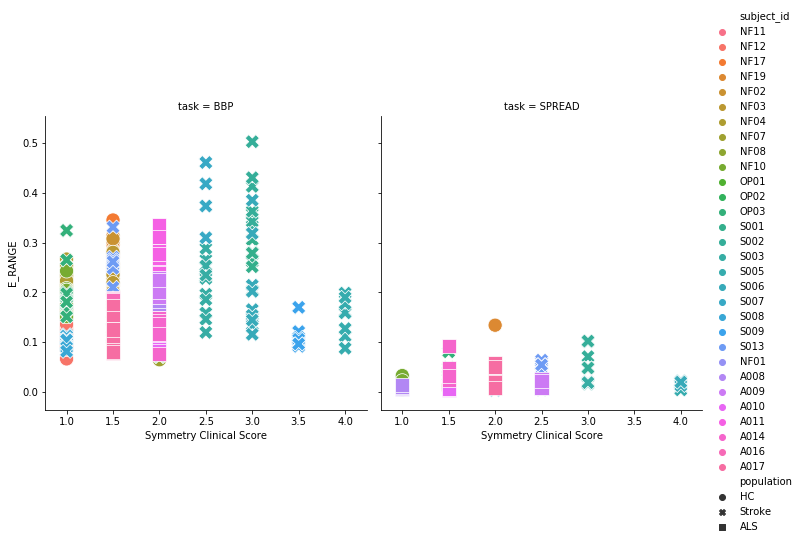

In [57]:

features_symmetry = ['D_1', 'D_3', 'R_LCRC','A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'R_SYMM', 'E_MEAN','E_RANGE']

score = 'Symmetry Clinical Score'


for t in fv_symmetry['task'].unique():
    task_df = fv_symmetry.loc[fv_symmetry['task']==t]
    for f in features_symmetry:
        corr, p_value = spearmanr(task_df[f], task_df[score])
        print('Spearmans correlation between {} and {} for task {}: %.3f'.format(f, score, t) % corr)
        print('p_value: %.9f'% p_value)
        print()

for f in features_symmetry:
    #task = fv_symmetry.task[337]
    g = sns.relplot(x=score, y=f, data=fv_symmetry, kind = 'scatter', 
                    col = 'task',hue = 'subject_id',style ='population', s=200)
   # plt.title('The scatter plot between {} and {}'.format(f, score ))
    
    plt.xlabel('Symmetry Clinical Score')
    plt.ylabel('SLP Clinical Score for ROM')
    #plt.title('Spearmans correlation between {} and {} for task {}: %.3f'.format(f, score, task) % corr)
    plt.savefig('face_valid_sym_{}_{}'.format(score, f), bbox_inches='tight')
    

array(['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD'], dtype=object)

In [ ]:
#fv_symmetry['A_MEAN'].loc[sub_neuro_df['subject_id'] == 'A009']

The A_mean and A_bs_diff must be differnt quantities but are the same thing here!

### Speed Validation

In [49]:
features_speed = ['O_MAX_VEL', 'O_MIN_VEL','W_MAX_VEL', 'W_MIN_VEL']



fv_speed = face_valid.loc[ (face_valid['task'] == 'NSM_SPREAD')|(face_valid['task'] == 'NSM_BIGSMILE')]


#fv_speed = face_valid.loc[ (face_valid['task'] == 'BBP_NORMAL')|(face_valid['task'] == 'NSM_OPEN')]
#fv_speed = fv_speed.loc[(fv_speed['population'] == 'Stroke') |(fv_speed['population'] == 'ALS')] 
      

#fv_speed = sub_neuro_df.loc[((sub_neuro_df['subject_id'] == 'NF08') | (sub_neuro_df['subject_id'] == 'A009')| 
#                              (sub_neuro_df['subject_id'] == 'S002') ) & 
#                             ((sub_neuro_df['task'] == 'NSM_SPREAD')|(sub_neuro_df['task'] == 'NSM_BIGSMILE')) ]



fv_speed = fv_speed.drop(['O_MAX', 'O_MIN', 'W_MAX', 'W_MIN',  'R_LCRC', 
       'D_1', 'D_2', 'D_3', 'LL_PATH',  'A_RANGE', 'A_ABS_DIFF',
       'A_CCC',  
       'R_SYMM', 'E_MEAN', 'E_RANGE'], axis=1)

features_speed  = [ 'O_MAX_VEL', 'O_MIN_VEL', 'W_MAX_VEL', 'W_MIN_VEL']

z_scores = stats.zscore(fv_speed[features_speed])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
fv_speed = fv_speed[filtered_entries]

print(fv_speed.columns)
print(fv_speed.shape)

Index(['subject_id', 'task', 'rep', 'O_MAX_VEL', 'O_MIN_VEL', 'W_MAX_VEL',
       'W_MIN_VEL', 'Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'population'],
      dtype='object')
(201, 14)


In [136]:
#fv_speed = fv_speed[fv_speed.subject_id != 'OP01']
#fv_speed = fv_speed[fv_speed.subject_id != 'OP02']
#fv_speed = fv_speed[fv_speed.subject_id != 'S013']

fv_speed = fv_speed[fv_speed.subject_id != 'OP01']
fv_speed = fv_speed[fv_speed.subject_id != 'OP02']
fv_speed = fv_speed[fv_speed.subject_id != 'A010']
fv_speed = fv_speed[fv_speed.subject_id != 'A011']
fv_speed = fv_speed[fv_speed.subject_id != 'A008']
fv_speed = fv_speed[fv_speed.subject_id != 'A016']
fv_speed = fv_speed[fv_speed.subject_id != 'S007']
fv_speed = fv_speed[fv_speed.subject_id != 'OP03']
fv_speed = fv_speed[fv_speed.subject_id != 'S005']
fv_speed = fv_speed[fv_speed.subject_id != 'S013']

In [50]:
fv_speed['task'].replace({'BBP_NORMAL':'BBP', 'NSM_BIGSMILE': 'BIG SMILE',
                            'NSM_SPREAD':'SPREAD','NSM_OPEN': 'OPEN'}, inplace=True)

fv_speed.rename(columns={'Speed_avg':'Speed Clinical Score'}, inplace=True)

Spearmans correlation between O_MAX_VEL and Speed Clinical Score for task SPREAD: -0.271
p_value: 0.000561807

Spearmans correlation between O_MIN_VEL and Speed Clinical Score for task SPREAD: 0.333
p_value: 0.000019072

Spearmans correlation between W_MAX_VEL and Speed Clinical Score for task SPREAD: -0.484
p_value: 0.000000000

Spearmans correlation between W_MIN_VEL and Speed Clinical Score for task SPREAD: 0.451
p_value: 0.000000003

Spearmans correlation between O_MAX_VEL and Speed Clinical Score for task BIG SMILE: -0.230
p_value: 0.137938494

Spearmans correlation between O_MIN_VEL and Speed Clinical Score for task BIG SMILE: 0.157
p_value: 0.314738762

Spearmans correlation between W_MAX_VEL and Speed Clinical Score for task BIG SMILE: -0.345
p_value: 0.023333900

Spearmans correlation between W_MIN_VEL and Speed Clinical Score for task BIG SMILE: 0.701
p_value: 0.000000163



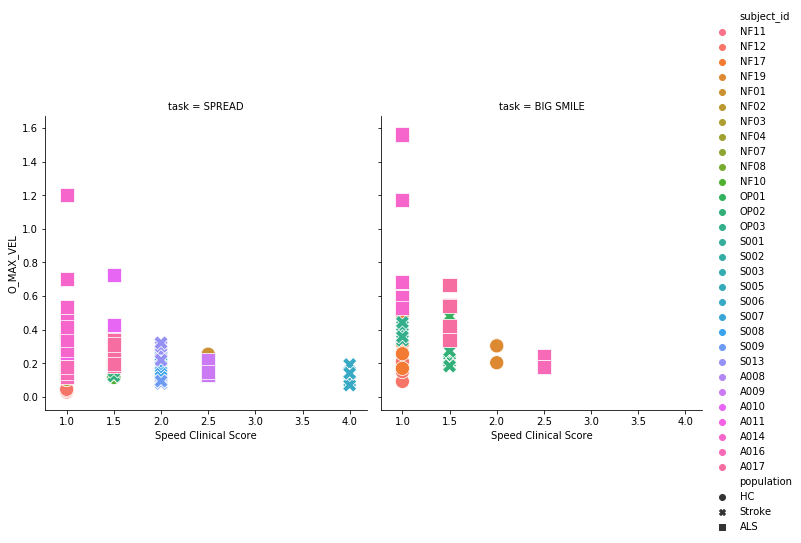

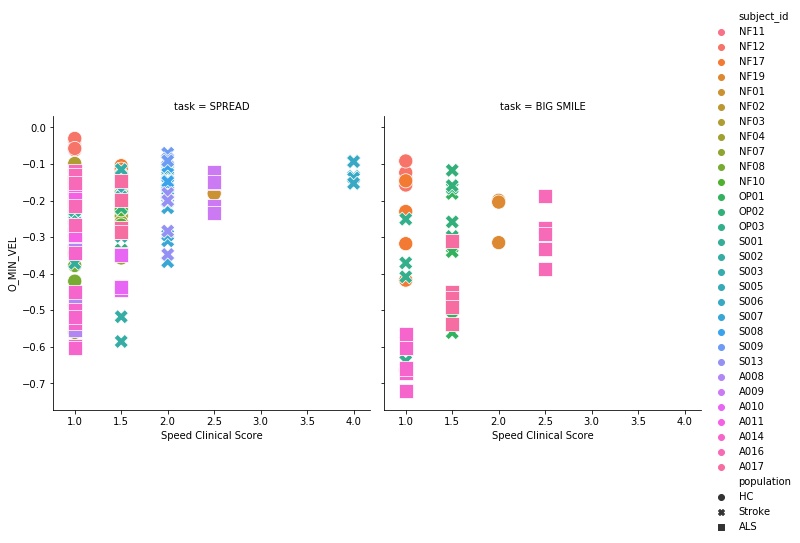

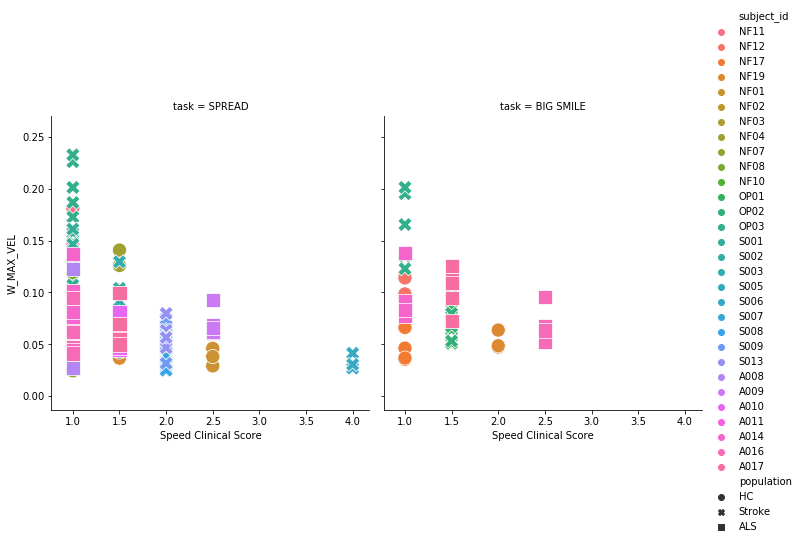

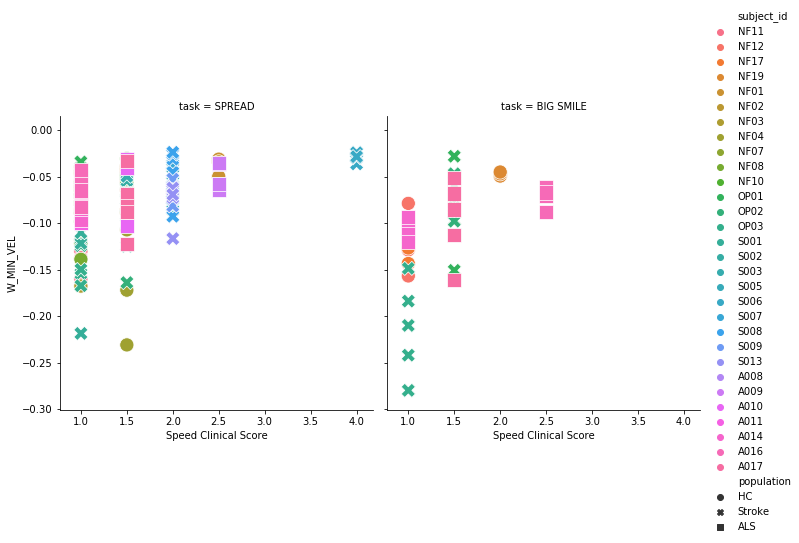

In [51]:
score = 'Speed Clinical Score'


for t in fv_speed['task'].unique():
    task_df = fv_speed.loc[fv_speed['task']==t]
    for f in features_speed:
        corr, p_value = spearmanr(task_df[f], task_df[score])
        print('Spearmans correlation between {} and {} for task {}: %.3f'.format(f, score, t) % corr)
        print('p_value: %.9f'% p_value)
        print()

        
for f in features_speed:

    g = sns.relplot(x=score, y=f, data=fv_speed, kind = 'scatter', col='task',hue = 'subject_id',
                   style ='population', s=200)
    #plt.title('The scatter plot between {} and {}'.format(f, score ))
    #corr, _ = spearmanr(fv_speed[f], fv_speed[score])
    #print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    #plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_speed_tsk_{}_{}'.format(score, f), bbox_inches='tight')
    

In [141]:
fv_speed_2 = face_valid.loc[ (face_valid['task'] == 'BBP_NORMAL')|(face_valid['task'] == 'NSM_OPEN')]
#fv_speed = fv_speed.loc[(fv_speed['population'] == 'Stroke') |(fv_speed['population'] == 'ALS')] 
      

#fv_speed = sub_neuro_df.loc[((sub_neuro_df['subject_id'] == 'NF08') | (sub_neuro_df['subject_id'] == 'A009')| 
#                              (sub_neuro_df['subject_id'] == 'S002') ) & 
#                             ((sub_neuro_df['task'] == 'NSM_SPREAD')|(sub_neuro_df['task'] == 'NSM_BIGSMILE')) ]



fv_speed_2 = fv_speed_2.drop(['O_MAX', 'O_MIN', 'W_MAX', 'W_MIN',  'R_LCRC', 
       'D_1', 'D_2', 'D_3', 'LL_PATH',  'A_RANGE', 'A_ABS_DIFF',
       'A_CCC',  
       'R_SYMM', 'E_MEAN', 'E_RANGE'], axis=1)


In [142]:
fv_speed_2['task'].replace({'BBP_NORMAL':'BBP', 'NSM_BIGSMILE': 'BIG SMILE',
                            'NSM_SPREAD':'SPREAD','NSM_OPEN': 'OPEN'}, inplace=True)

fv_speed_2.rename(columns={'Speed_avg':'Speed Clinical Score'}, inplace=True)

Spearmans correlation between O_MAX_VEL and Speed Clinical Score for task BBP: -0.062
p_value: 0.296520146

Spearmans correlation between O_MIN_VEL and Speed Clinical Score for task BBP: 0.047
p_value: 0.427322328

Spearmans correlation between W_MAX_VEL and Speed Clinical Score for task BBP: -0.045
p_value: 0.446678961

Spearmans correlation between W_MIN_VEL and Speed Clinical Score for task BBP: 0.066
p_value: 0.266516859

Spearmans correlation between O_MAX_VEL and Speed Clinical Score for task OPEN: -0.199
p_value: 0.013859237

Spearmans correlation between O_MIN_VEL and Speed Clinical Score for task OPEN: 0.215
p_value: 0.007567259

Spearmans correlation between W_MAX_VEL and Speed Clinical Score for task OPEN: 0.001
p_value: 0.992147058

Spearmans correlation between W_MIN_VEL and Speed Clinical Score for task OPEN: -0.016
p_value: 0.846982161



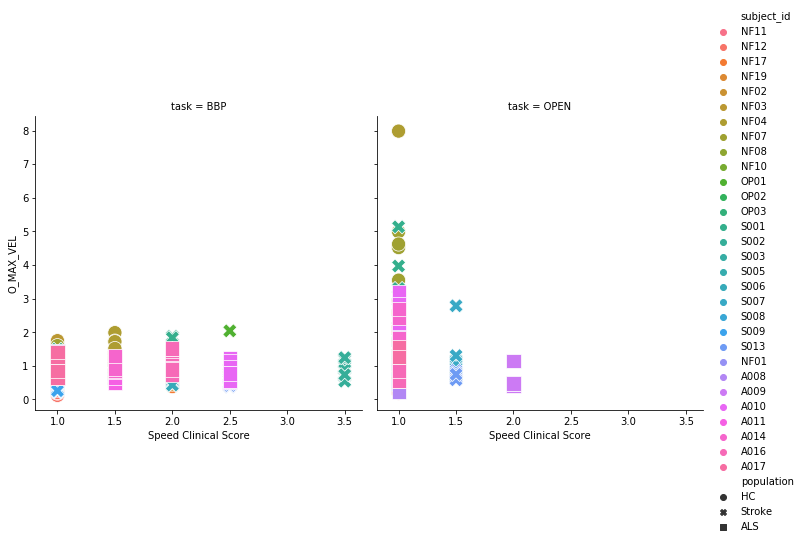

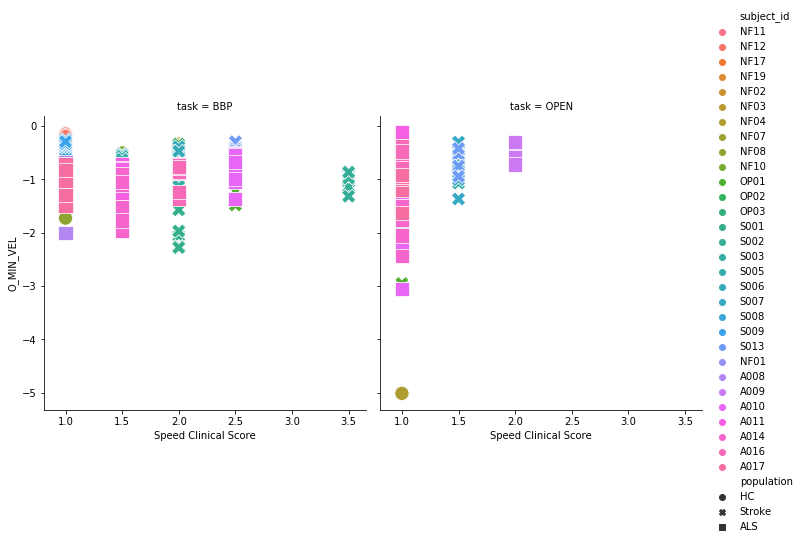

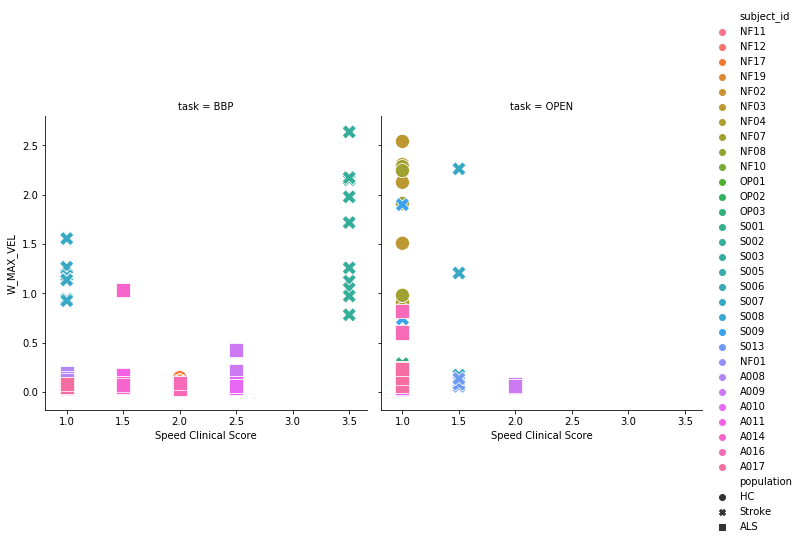

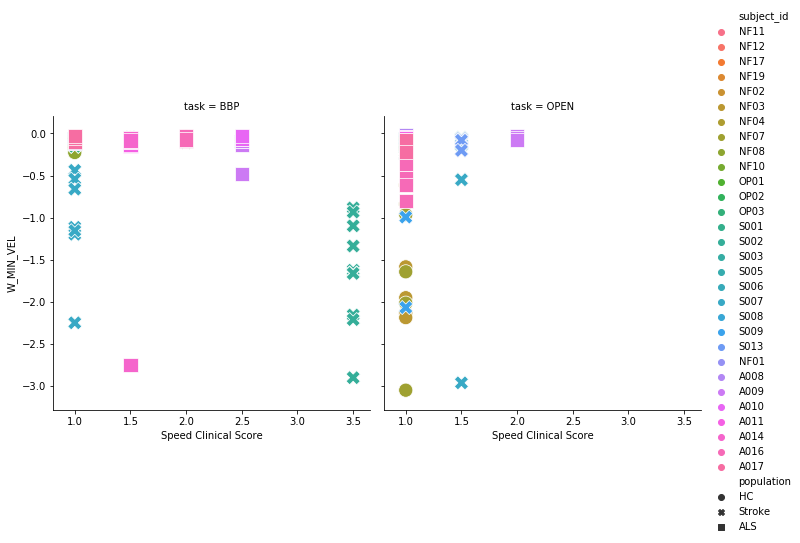

In [144]:
score = 'Speed Clinical Score'


for t in fv_speed_2['task'].unique():
    task_df = fv_speed_2.loc[fv_speed_2['task']==t]
    for f in features_speed:
        corr, p_value = spearmanr(task_df[f], task_df[score])
        print('Spearmans correlation between {} and {} for task {}: %.3f'.format(f, score, t) % corr)
        print('p_value: %.9f'% p_value)
        print()


z_scores = stats.zscore(fv_speed_2[features_speed])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
fv_speed_2 = fv_speed_2[filtered_entries]
        
for f in features_speed:

    g = sns.relplot(x=score, y=f, data=fv_speed_2, kind = 'scatter', col='task',hue = 'subject_id',
                   style ='population', s=200)
 
    plt.savefig('face_valid_speed_tsk_{}_{}'.format(score, f), bbox_inches='tight')
    

In [ ]:
# filtering out the outliers 

z_scores = stats.zscore(fv_speed[features_speed])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
fv_speed_olr = fv_speed[filtered_entries]


for f in features_speed:

    g = sns.relplot(x=score, y=f, data=fv_speed_olr, kind = 'scatter', hue = 'subject_id')
    
    corr, _ = spearmanr(fv_speed_olr[f], fv_speed_olr[score])
    
    plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_speed_olr_{}_{}'.format(score, f), bbox_inches='tight')
    

### ROM Validation 

In [52]:
features_rom = ['O_MAX', 'O_MIN', 'W_MAX', 'W_MIN', 
             'LL_PATH', 'A_RANGE']

fv_rom = face_valid[ (face_valid['task'] == 'NSM_SPREAD')|(face_valid['task'] == 'NSM_BIGSMILE')]

#fv_rom = face_valid.loc[ (face_valid['task'] == 'BBP_NORMAL')|(face_valid['task'] == 'NSM_OPEN')]


fv_rom = fv_rom.loc[(fv_rom['population'] == 'Stroke') |(fv_rom['population'] == 'ALS')] 


#fv_rom = sub_neuro_df.loc[((sub_neuro_df['subject_id'] == 'NF07') & ((sub_neuro_df['task'] == 'NSM_SPREAD')|(sub_neuro_df['task'] == 'NSM_BIGSMILE')))
#            |((sub_neuro_df['subject_id'] == 'NF09') & ((sub_neuro_df['task'] == 'NSM_BIGSMILE')|(sub_neuro_df['task'] == 'NSM_SPREAD')))
#      | ((sub_neuro_df['subject_id'] == 'A009') & ((sub_neuro_df['task'] == 'NSM_BIGSMILE')|(sub_neuro_df['task'] == 'NSM_SPREAD'))) 
#         | ((sub_neuro_df['subject_id'] == 'S007') & ((sub_neuro_df['task'] == 'NSM_BIGSMILE')|(sub_neuro_df['task'] == 'NSM_SPREAD'))) 
#        |    ((sub_neuro_df['subject_id'] == 'S006') & ((sub_neuro_df['task'] == 'NSM_SPREAD')|(sub_neuro_df['task'] == 'NSM_BIGSMILE'))) ]


fv_rom = fv_rom.drop(['O_MAX_VEL', 'O_MIN_VEL', 'W_MAX_VEL', 'W_MIN_VEL', 
                      'R_LCRC',  'D_1', 'D_2', 'D_3',  
    'A_ABS_DIFF', 'A_CCC',  
       'R_SYMM', 'E_MEAN', 'E_RANGE'], axis=1)


features_rom  = [ 'O_MAX', 'O_MIN', 'W_MAX', 'W_MIN', 'LL_PATH', 'A_RANGE']

z_scores = stats.zscore(fv_rom[features_rom])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
fv_rom = fv_rom[filtered_entries]

print(fv_rom.columns)
print(fv_rom.shape)
print(fv_rom.task.unique())

Index(['subject_id', 'task', 'rep', 'O_MAX', 'O_MIN', 'W_MAX', 'W_MIN',
       'LL_PATH', 'A_RANGE', 'Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'population'],
      dtype='object')
(125, 16)
['NSM_SPREAD' 'NSM_BIGSMILE']


In [126]:
#fv_rom = sub_neuro_df.loc[((sub_neuro_df['subject_id'] == 'NF07') & ((sub_neuro_df['task'] == 'NSM_OPEN')|(sub_neuro_df['task'] == 'BBP_NORMAL')))
#           |((sub_neuro_df['subject_id'] == 'NF09') & ((sub_neuro_df['task'] == 'NSM_OPEN')|(sub_neuro_df['task'] == 'BBP_NORMAL')))
#      | ((sub_neuro_df['subject_id'] == 'A009') & ((sub_neuro_df['task'] == 'NSM_OPEN')|(sub_neuro_df['task'] == 'BBP_NORMAL'))) 
#         | ((sub_neuro_df['subject_id'] == 'S007') & ((sub_neuro_df['task'] == 'NSM_OPEN')|(sub_neuro_df['task'] == 'BBP_NORMAL'))) 
#        |    ((sub_neuro_df['subject_id'] == 'S006') & ((sub_neuro_df['task'] == 'NSM_OPEN')|(sub_neuro_df['task'] == 'BBP_NORMAL'))) ]



print(fv_rom.columns)
print(fv_rom.shape)
print(fv_rom.task.unique())

Index(['subject_id', 'task', 'rep', 'O_MAX', 'O_MIN', 'W_MAX', 'W_MIN',
       'LL_PATH', 'A_RANGE', 'Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'population'],
      dtype='object')
(133, 16)
['NSM_SPREAD' 'NSM_BIGSMILE']


In [127]:
fv_rom = fv_rom[fv_rom.subject_id != 'OP01']
fv_rom = fv_rom[fv_rom.subject_id != 'OP02']
fv_rom = fv_rom[fv_rom.subject_id != 'A010']
fv_rom = fv_rom[fv_rom.subject_id != 'A011']
fv_rom = fv_rom[fv_rom.subject_id != 'A008']
fv_rom = fv_rom[fv_rom.subject_id != 'A016']
fv_rom = fv_rom[fv_rom.subject_id != 'S007']
fv_rom = fv_rom[fv_rom.subject_id != 'OP03']
fv_rom = fv_rom[fv_rom.subject_id != 'S005']
fv_rom = fv_rom[fv_rom.subject_id != 'S013']

In [53]:
fv_rom['task'].replace({'BBP_NORMAL':'BBP', 'NSM_BIGSMILE': 'BIG SMILE',
                            'NSM_SPREAD':'SPREAD','NSM_OPEN': 'OPEN'}, inplace=True)

fv_rom.rename(columns={'ROM_avg':'ROM Clinical Score'}, inplace=True)

Spearmans correlation between O_MAX and ROM Clinical Score for task SPREAD: -0.518
p_value: 0.000000063

Spearmans correlation between O_MIN and ROM Clinical Score for task SPREAD: -0.381
p_value: 0.000131039

Spearmans correlation between W_MAX and ROM Clinical Score for task SPREAD: -0.354
p_value: 0.000395394

Spearmans correlation between W_MIN and ROM Clinical Score for task SPREAD: 0.413
p_value: 0.000028766

Spearmans correlation between LL_PATH and ROM Clinical Score for task SPREAD: 0.370
p_value: 0.000209912

Spearmans correlation between A_RANGE and ROM Clinical Score for task SPREAD: -0.283
p_value: 0.005144529

Spearmans correlation between O_MAX and ROM Clinical Score for task BIG SMILE: -0.156
p_value: 0.419180346

Spearmans correlation between O_MIN and ROM Clinical Score for task BIG SMILE: 0.065
p_value: 0.737708850

Spearmans correlation between W_MAX and ROM Clinical Score for task BIG SMILE: -0.308
p_value: 0.104570924

Spearmans correlation between W_MIN and ROM C

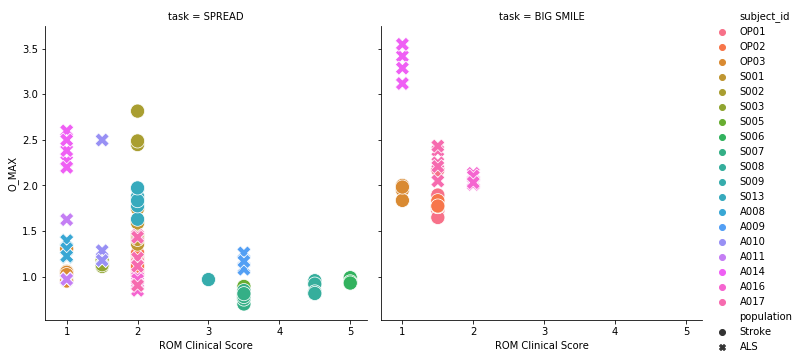

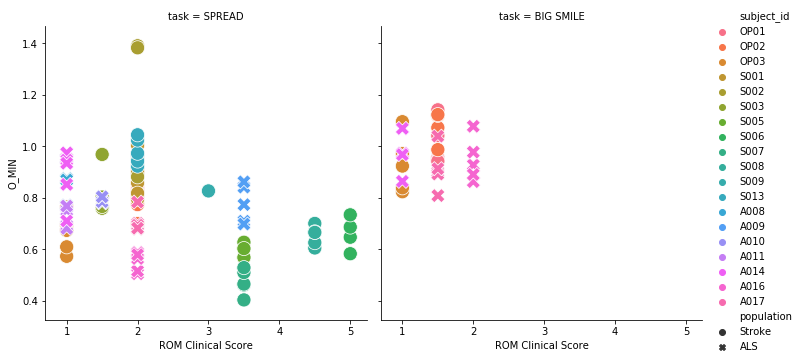

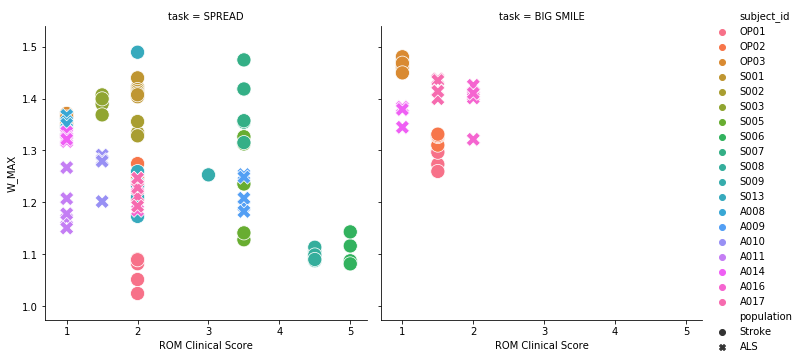

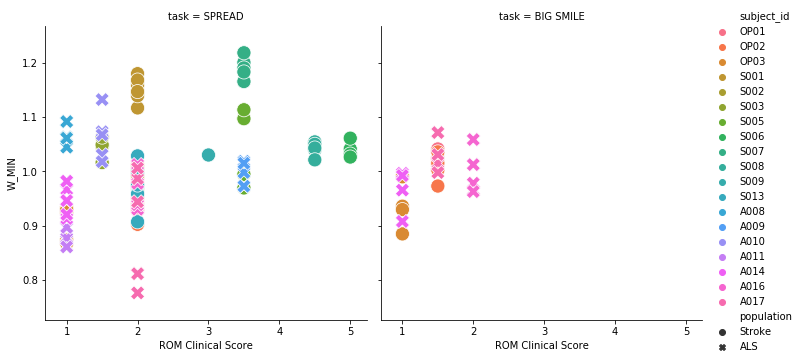

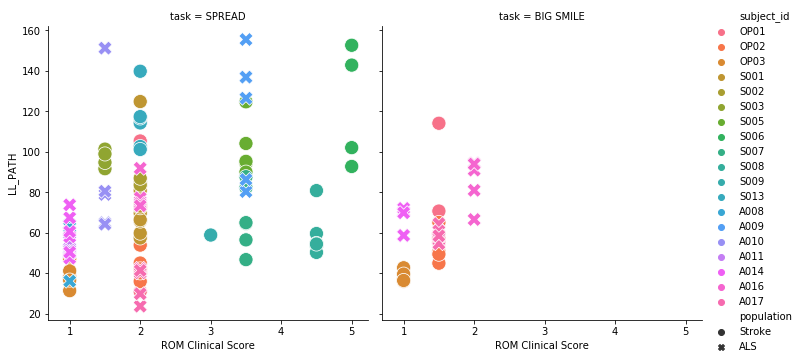

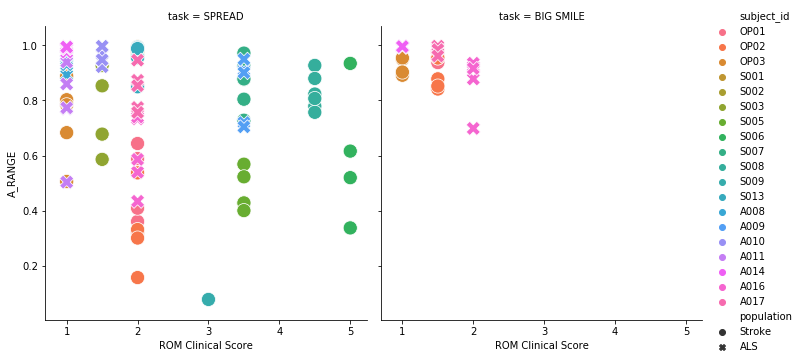

In [54]:
score = 'ROM Clinical Score'


for t in fv_rom['task'].unique():
    task_df = fv_rom.loc[fv_rom['task']==t]
    for f in features_rom:
        corr, p_value = spearmanr(task_df[f], task_df[score])
        print('Spearmans correlation between {} and {} for task {}: %.3f'.format(f, score, t) % corr)
        print('p_value: %.9f'% p_value)
        print()


for f in features_rom:

    g = sns.relplot(x=score, y=f, data=fv_rom, kind = 'scatter',  col ='task', hue = 'subject_id',style ='population', s=200)
    #plt.title('The scatter plot between {} and {}'.format(f, score ))
    #corr, _ = spearmanr(fv_rom[f], fv_rom[score])
    #print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    #plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_ROM_{}_{}'.format(score, f), bbox_inches='tight')

### THE END OF FACE VALIDITY 

In [ ]:
# standardized 
# read stroke data 

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE

features = ['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL','W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH', 
            'R_LCRC', 'D_0','D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF','A_CCC', 'WIDTH_MAX',
            'WIDTH_MEAN', 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN','HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX', 
            'HEIGHT_VEL_MIN','R_SYMM', 'E_MEAN', 'E_RANGE']
print(len(features))


stroke_df = pd.DataFrame()

for task in range(len(tasks)):
    
    stroke_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/stroke/metric_output_"+tasks[task]+"_standardized.csv"    
    df = pd.read_csv(stroke_file)
    df = df.drop('Unnamed: 0', axis=1)
    stroke_df = pd.concat([stroke_df, df], ignore_index=True)
        
print(stroke_df.shape)
print(stroke_df.subject_id.unique())


# read als
als_df = pd.DataFrame()

for task in range(len(tasks)):

    als_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/als/metric_output_"+tasks[task]+"_standardized.csv"
    df = pd.read_csv(als_file)
    df = df.drop('Unnamed: 0', axis=1)
    als_df = pd.concat([als_df, df], ignore_index=True)

print(als_df.shape)
print(als_df.subject_id.unique())

# merge the two feature dfs into one feature df
feature_df_std = pd.concat([stroke_df, als_df], ignore_index=True)
print(feature_df.shape)


print('SLP Scores df: ',slp_scores['Subject ID'].unique())
feature_df_std.head()



In [ ]:
sub_neuro_df_std = feature_df_std.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

face_valid_std = sub_neuro_df_std.loc[(sub_neuro_df_std['subject_id'] == 'NF08') | (sub_neuro_df_std['subject_id'] == 'A009')| 
                              (sub_neuro_df_std['subject_id'] == 'S006') | (sub_neuro_df_std['subject_id'] == 'S009')]
sub_neuro_df_std = sub_neuro_df_std.drop(['type','File Name',
       'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)', 'Speed (SLP1)',
       'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)', 'Symmetry (SLP2)',
       'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)', 'Fatigue (SLP2)',
       'Tot (SLP2)' ], axis=1)

print(sub_neuro_df.columns)
print(len(sub_neuro_df.columns))
print(sub_neuro_df.shape)

In [ ]:
# speed
fv_speed_std = sub_neuro_df_std.loc[((sub_neuro_df_std['subject_id'] == 'NF08') | (sub_neuro_df_std['subject_id'] == 'A009')| 
                              (sub_neuro_df_std['subject_id'] == 'S002') ) & 
                             (sub_neuro_df_std['task'] == 'BBP_NORMAL') ]


fv_speed_std = fv_speed_std.drop(['O_MAX', 'O_MIN', 'W_MAX', 'W_MIN', 'A_MOUTH', 'R_LCRC', 'D_0',
       'D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF',
       'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'HEIGHT_MAX', 'HEIGHT_MIN', 
       'R_SYMM', 'E_MEAN', 'E_RANGE'], axis=1)

print(fv_speed_std.columns)
print(fv_speed_std.shape)

In [ ]:
for f in features_speed:

    g = sns.relplot(x=score, y=f, data=fv_speed_std, kind = 'scatter', hue = 'subject_id')
    #plt.title('The scatter plot between {} and {}'.format(f, score ))
    corr, _ = spearmanr(fv_speed[f], fv_speed[score])
    #print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_speed_std_{}_{}'.format(score, f), bbox_inches='tight')
    

In [ ]:
spread_sym_std = face_valid_std.loc[face_valid_std['task'] == 'NSM_SPREAD']
spread_sym_std = spread_sym_std.drop(['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL',
       'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'LL_PATH' , 'WIDTH_MAX', 'WIDTH_MEAN', 
                 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN',
       'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN',], axis=1)


In [ ]:
# ROM
fv_rom_std = sub_neuro_df_std.loc[((sub_neuro_df_std['subject_id'] == 'NF08') & (sub_neuro_df_std['task'] == 'NSM_SPREAD'))
            |((sub_neuro_df_std['subject_id'] == 'NF11') & (sub_neuro_df_std['task'] == 'BBP_NORMAL'))
      | ((sub_neuro_df_std['subject_id'] == 'A009') & ((sub_neuro_df_std['task'] == 'BBP_NORMAL')|(sub_neuro_df_std['task'] == 'NSM_SPREAD'))) 
         | ((sub_neuro_df_std['subject_id'] == 'S005') & (sub_neuro_df_std['task'] == 'BBP_NORMAL')) 
        |    ((sub_neuro_df_std['subject_id'] == 'S006') & (sub_neuro_df_std['task'] == 'NSM_SPREAD')) ]



fv_rom_std = fv_rom_std.drop(['O_MAX_VEL', 'O_MIN_VEL', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
                      'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3',  
    'A_ABS_DIFF', 'A_CCC',  'WIDTH_VEL_MAX','WIDTH_VEL_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'], axis=1)


print(fv_rom_std.columns)
print(fv_rom_std.shape)
#fv_rom

for f in features_rom:

    g = sns.relplot(x=score, y=f, data=fv_rom_std, kind = 'scatter', col ='task', hue = 'subject_id')
    #plt.title('The scatter plot between {} and {}'.format(f, score ))
    corr, _ = spearmanr(fv_rom[f], fv_rom[score])
    print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    #plt.title('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)
    plt.savefig('face_valid_ROM_std_{}_{}'.format(score, f), bbox_inches='tight')
    

In [ ]:

# run features vs scores corrolation analysis and scatter plots 
corr = sub_neuro_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), 
               cmap=sns.diverging_palette(220, 10, as_cmap=True),center=0.00, linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.title('Feature Correlations with Clinical Scores')
plt.show()



In [ ]:
scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores:

    for f in features:
        
        g = sns.relplot(x=score, y=f, data=sub_neuro_df, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(sub_neuro_df[f], sub_neuro_df[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
corr = feature_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
g =sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
               center=0.00,cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.title('Feature Correlations')
plt.show()

In [ ]:
# run the avg and std
### Taking the average and std of the features over all the repetitions per task per participant 
task_avg_st = sub_neuro_df.groupby(['subject_id','task'])[['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL',
       'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH', 'R_LCRC', 'D_0',
       'D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF',
       'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN',
       'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN',
       'R_SYMM', 'E_MEAN', 'E_RANGE', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg']].agg([np.mean, np.std])

#print(task_avg_st.shape)
#print(task_avg_st.columns)

corr = task_avg_st.corr()
corr.columns = [''.join(col) for col in corr.columns]
corr = corr.dropna(axis = 1, how='all')
corr = corr.dropna(axis = 0, how='all')

ax, figure = plt.subplots(figsize=(14,20))
sub_corr = corr[['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), 
               cmap=sns.diverging_palette(220, 10, as_cmap=True),center=0.00, linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.title('Avg and SD of Features across Reps')
plt.show()

In [ ]:
task_avg_st.head()

In [ ]:
scores_2 = ['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']

for score in scores_2:

    for f in features:
        
        g = sns.relplot(x=score, y=f, data=task_avg_st, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('All_AcrossReps_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(task_avg_st[f], task_avg_st[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
# trend corrolation analysis and scatter plots 

In [ ]:
# Calculating the trend fro fatigue 

first_rep = sub_neuro_df.loc[sub_neuro_df.groupby(['subject_id','task'])['rep'].idxmin()]

last_rep = sub_neuro_df.loc[sub_neuro_df.groupby(['subject_id','task'])['rep'].idxmax()]

trend_df = pd.DataFrame()
trend_df[features] = first_rep[features] - last_rep[features].values


#.apply(lambda x: x.rep.max() - x.rep.min())

print(trend_df.shape)
trend_df

In [ ]:
trend_df = pd.merge(trend_df, sub_neuro_df[['task','Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg','Variability_avg',
                                            'Fatigue_avg']], left_index = True, right_index=True)

In [ ]:
corr = trend_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool),
               cmap=sns.diverging_palette(220, 10, as_cmap=True), center=0.00,linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

# Fine-Tuned Diego's Results 

In [ ]:
def print_prop(df, file):
    print(file)
    print('Shape: ',df.shape)
    print()
    print(df.columns)
    print()
    print('Total Number of Subjects in Df are: ', len(df.subject_id.unique()))
    print("Subjects IDs are: ",df.subject_id.unique())

    print()



### Diego Stroke DATA 

In [ ]:
### STROKE DATA

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE

stroke_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_4 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


bbp_s_df_1 = pd.read_csv(stroke_file_1)
bbp_s_df_1 = bbp_s_df_1.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_1, stroke_file_1)



bbp_s_df_2 = pd.read_csv(stroke_file_2)
bbp_s_df_2 = bbp_s_df_2.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_2, stroke_file_2)



bbp_s_df_3 = pd.read_csv(stroke_file_3)
bbp_s_df_3 = bbp_s_df_3.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_3, stroke_file_3)



bbp_s_df_4 = pd.read_csv(stroke_file_4)
bbp_s_df_4 = bbp_s_df_4.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_4, stroke_file_4)

In [ ]:
bbp_s_df_1.head()

In [ ]:
print('1 includes 2: ', set(bbp_s_df_2.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))
print('1 includes 3: ', set(bbp_s_df_3.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))
print('1 includes 4: ', set(bbp_s_df_4.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))

In [ ]:
for task in range(len(tasks)):
    
    stroke_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_4 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


    print(tasks[task])
    try: 
        df_1 = pd.read_csv(stroke_file_1)
        #df_1 = df_1.drop('Unnamed: 0', axis=1)
        print("df1 shape: ", df_1.shape)
        df_2 = pd.read_csv(stroke_file_2)
        #df_2 = df_2.drop('Unnamed: 0', axis=1)
        print("df2 shape: ", df_2.shape)
        df_3 = pd.read_csv(stroke_file_3)
        #df_3 = df_3.drop('Unnamed: 0', axis=1)
        print("df3 shape: ", df_3.shape)
        df_4 = pd.read_csv(stroke_file_4)
        print("df4 shape: ", df_4.shape)
        #df_4 = df_4.drop('Unnamed: 0', axis=1)
        
    except: 
        pass

    print('1 includes 2: ', set(df_2.subject_id.unique()).issubset(df_1.subject_id.unique()))
    print('1 includes 3: ', set(df_3.subject_id.unique()).issubset(df_1.subject_id.unique()))
    print('1 includes 4: ', set(df_4.subject_id.unique()).issubset(df_1.subject_id.unique()))


In [ ]:
stroke_df = pd.DataFrame()

for task in range(len(tasks)):
    
    stroke_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
    
    df = pd.read_csv(stroke_file)
    df = df.drop('Unnamed: 0', axis=1)
    stroke_df = pd.concat([stroke_df, df], ignore_index=True)

    
    
print(stroke_df.shape)



In [ ]:
stroke_df['population'] = [pop_labeler(x) for x in stroke_df['subject_id']]
stroke_df.head()

In [ ]:

print('len: ' , len(stroke_df))
print(len(stroke_df.columns))
print(stroke_df.columns)
print(stroke_df.groupby(['population']).subject_id.unique())
print(stroke_df.task.unique())

with np.printoptions(threshold=np.inf):
    print(stroke_df.groupby(['population']).subject_id.unique())
    print(len(stroke_df.subject_id.unique()))
    
print(np.intersect1d(stroke_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(stroke_df.subject_id.unique(),neuroface_subjects)))

In [ ]:
len(stroke_df.groupby(['population']).subject_id.unique()['Stroke'])

In [ ]:
stroke_df.groupby(['population','task']).count()

In [ ]:
# TASKS 
ax, figure = plt.subplots(figsize=(10,7))
g = sns.countplot(x='task',data=stroke_df,hue='population')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of reps')
plt.title('Total Number of reps analyzed for each clinical task')
plt.show()

# Getting the corrolations based on the common data with clinical scores 

In [ ]:
slp_scores

In [ ]:
stroke_df

In [ ]:
stroke_and_scores = stroke_df.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

print(len(stroke_and_scores.subject_id.unique()))
print(stroke_and_scores.subject_id.unique())
print(stroke_and_scores.task.unique())

print(stroke_df.shape)
print(stroke_and_scores.shape)
print(stroke_and_scores.columns)

In [ ]:
# filtering out the outliers 

z_scores = stats.zscore(stroke_and_scores[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_stroke_and_scores = stroke_and_scores[filtered_entries]

print(new_stroke_and_scores.shape)

In [ ]:
just_stroke = new_stroke_and_scores.loc[new_stroke_and_scores['type']== 1]

z_scores = stats.zscore(just_stroke[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
just_stroke = just_stroke[filtered_entries]

print(just_stroke.shape)


In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

tasks = ['BBP_NORMAL', 'NSM_OPEN' ,'NSM_SPREAD' ,'NSM_BIGSMILE']

scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores:

    for f in stroke_features:
        
        g = sns.relplot(x=score, y=f, data=just_stroke, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(just_stroke[f], just_stroke[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

        # calculate spearman's correlation

### Figuring out the trend by Trend = 1st repetition feature values - Last repetition feature values 
### for each task per participant 

In [ ]:
# Calculating the trend fro fatigue 

first_rep = just_stroke.loc[just_stroke.groupby(['subject_id','task'])['rep'].idxmin()]

last_rep = just_stroke.loc[just_stroke.groupby(['subject_id','task'])['rep'].idxmax()]

trend_df = pd.DataFrame()
trend_df[['O_MAX_diff', 'O_MIN_diff','O_MAX_VEL_diff', 'O_MIN_VEL_diff', 'W_MAX_diff', 'W_MIN_diff', 'W_MAX_VEL_diff', 'W_MIN_VEL_diff',
       'A_MOUTH_diff', 'R_LCRC_diff', 'D_0_diff', 'D_1_diff', 'D_2_diff', 'D_3_diff']] = first_rep[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']] - last_rep[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']].values


#.apply(lambda x: x.rep.max() - x.rep.min())

print(trend_df.shape)
trend_df

In [ ]:
trend_df = pd.merge(trend_df, just_stroke[['task','Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']], left_index = True, right_index=True)

In [ ]:
# Scatter plot for the trend 

for score in scores:

    for f in stroke_features:
        
        g = sns.relplot(x=score, y=f+'_diff', data=trend_df, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_4corPlots_{}_{}'.format(score, f+'_diff'))
        corr, _ = spearmanr(just_stroke[f], just_stroke[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
corr = trend_df.corr()

In [ ]:
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# working example of agg with definition of fuction 

def diff(x):
    return np.max(x) - np.min(x)

just_stroke.groupby(['subject_id','task'])['rep'].agg([np.max,np.min, diff])

### Taking the average and std of the features over all the repetitions per task per participant 

In [ ]:
### Taking the average and std of the features over all the repetitions per task per participant 
stroke_task_avg = just_stroke.groupby(['subject_id','task'])[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']].agg([np.mean, np.std])

print(stroke_task_avg.shape)
print(stroke_task_avg.columns)

In [ ]:
corr = stroke_task_avg.corr()

In [ ]:
corr.columns = [''.join(col) for col in corr.columns]
corr = corr.dropna(axis = 1, how='all')
corr = corr.dropna(axis = 0, how='all')

ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# raw data corrolations and scatter plots between each feature and a single clinical score 

stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

tasks = ['BBP_NORMAL', 'NSM_OPEN' ,'NSM_SPREAD' ,'NSM_BIGSMILE']



for score in scores:

    for task in tasks: 
        for f in stroke_features:
            plt.figure()
            ax, figure = plt.subplots(figsize=(10,7))
            score = 'ROM_avg'
            sns.scatterplot(x=score, y=f, data=just_stroke, hue='task')
            plt.title('The scatter plot between {} and {}'.format(f, score ))

            # calculate spearman's correlation
            #corr, _ = spearmanr(stroke_and_scores[f], stroke_and_scores[score])
            #print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
# outliers removed scatter plot and corrolations between each feature and a single clinical score 
scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores: 
    
    for f in stroke_features:
        plt.figure()
        ax, figure = plt.subplots(figsize=(10,7))
        
        sns.scatterplot(x=score, y=f, data=just_stroke, hue='task', style='population_y')
        plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_{}_{}'.format(score, f))

        # calculate spearman's correlation
        corr, _ = spearmanr(new_stroke_and_scores[f], new_stroke_and_scores[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
new_stroke_and_scores.columns

In [ ]:
sub_stroke = new_stroke_and_scores[['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'population_y']]

In [ ]:
corr = sub_stroke.corr()

In [ ]:
ax, figure = plt.subplots(figsize=(14,10))
sub_corr_f = corr[['rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
sub_corr_f = sub_corr_f.drop(['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg'], axis=0)
g =sns.heatmap(sub_corr_f, mask=np.zeros_like(sub_corr_f, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# corrolation of clinical scores to themselves and the features 

ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:

ax, figure = plt.subplots(figsize=(14,10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(corr, mask=mask, vmax=.3, square=True)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

### Diego ALS DATA 

In [ ]:
### ALS DATA
tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE
als_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
als_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
als_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


bbp_als_df_1 = pd.read_csv(als_file_1)
bbp_als_df_1 = bbp_als_df_1.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_1, als_file_1)


bbp_als_df_2 = pd.read_csv(als_file_2)
bbp_als_df_2 = bbp_als_df_2.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_2, als_file_2)


bbp_als_df_3 = pd.read_csv(als_file_3)
bbp_als_df_3 = bbp_als_df_3.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_3, als_file_3)



In [ ]:
print('3 includes 1: ', set(bbp_als_df_1.subject_id.unique()).issubset(bbp_als_df_3.subject_id.unique()))

print('2 includes 1: ', set(bbp_als_df_1.subject_id.unique()).issubset(bbp_als_df_2.subject_id.unique()))

print(bbp_als_df_1.subject_id.unique())
print(bbp_als_df_2.subject_id.unique())
print(bbp_als_df_3.subject_id.unique())

In [ ]:
bbp_als_df_1.loc[bbp_als_df_1['subject_id'] == 'A008']

In [ ]:
bbp_als_df_3.loc[bbp_als_df_3['subject_id'] == 'A008']

In [ ]:
diego_bbp = bbp_als_df_1.merge(bbp_als_df_2)
diego_bbp = diego_bbp.merge(bbp_als_df_3)
uncommon_1 = bbp_als_df_1.loc[~bbp_als_df_1.subject_id.isin(diego_bbp.subject_id)]
uncommon_2 = bbp_als_df_2.loc[~bbp_als_df_2.subject_id.isin(diego_bbp.subject_id)]
uncommon_3 = bbp_als_df_3.loc[~bbp_als_df_3.subject_id.isin(diego_bbp.subject_id)]

print('shapes: ',uncommon_1.shape, uncommon_2.shape, uncommon_3.shape)

diego_bbp = pd.concat([diego_bbp, uncommon_1, uncommon_2, uncommon_3], ignore_index=True)

print_prop(diego_bbp, als_file_3)

In [ ]:
als_df = pd.DataFrame()

for task in range(len(tasks)):
    als_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
    als_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
    als_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"
    
    try: 
        als_df_1 = pd.read_csv(als_file_1)
    except:
        pass
    try:
        als_df_2 = pd.read_csv(als_file_2)
    except:
        pass
    try:
        als_df_3 = pd.read_csv(als_file_3)
    except:
        pass
    als_df = pd.concat([als_df, als_df_1, als_df_2, als_df_3], ignore_index=True)



    
print(als_df.shape)


In [ ]:
als_df = als_df.drop_duplicates()

als_df = als_df.drop('Unnamed: 0', axis=1)

In [ ]:
print(len(als_df_1.groupby(['population']).subject_id.unique()['ALS']))
print(len(als_df_1.groupby(['population']).subject_id.unique()['HC']))
print(als_df_1.groupby(['population']).subject_id.unique()['ALS'])
print(als_df_1.groupby(['population']).subject_id.unique()['HC'])

In [ ]:
als_df['population'] = [pop_labeler(x) for x in als_df['subject_id']]

In [ ]:
print(als_df.shape)
print(als_df.columns)
print(als_df.task.unique())
print(als_df.subject_id.unique())
print(len(als_df.subject_id.unique()))
print(len(als_df.groupby(['population']).subject_id.unique()['ALS']))
print(len(als_df.groupby(['population']).subject_id.unique()['HC']))
print(als_df.groupby(['population']).subject_id.unique()['ALS'])
print(als_df.groupby(['population']).subject_id.unique()['HC'])

In [ ]:
# Print the needed info 

print(np.intersect1d(als_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(als_df.subject_id.unique(),neuroface_subjects)))

In [ ]:
als_df

In [ ]:
als_and_scores = als_df.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

print(len(als_and_scores.subject_id.unique()))
print(als_and_scores.subject_id.unique())
print(als_and_scores.task.unique())

print(als_df.shape)
print(als_and_scores.shape)
print(als_and_scores.columns)

In [ ]:
# raw data corrolations and scatter plots between each feature and a single clinical score 

als_features = ['LL_PATH', 'A_MEAN', 'A_RANGE','A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 
                   'WIDTH_VEL_MAX','WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']

for f in als_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    score = 'ROM_avg'
    sns.scatterplot(x=score, y=f, data=als_and_scores, hue='task', style='population_y')
    plt.title('The scatter plot between {} and {}'.format(f, score ))

    # calculate spearman's correlation
    corr, _ = spearmanr(als_and_scores[f], als_and_scores[score])
    print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
# filtering out the outliers 

z_scores = stats.zscore(als_and_scores[['LL_PATH', 'A_MEAN', 'A_RANGE','A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 
                   'WIDTH_VEL_MAX','WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_als_and_scores = als_and_scores[filtered_entries]

print(new_als_and_scores.shape)

In [ ]:
#f, axes = plt.subplots(4, 4, figsize=(7, 7))

scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']
for score in scores: 
    for f in als_features:
        plt.figure()
        ax, figure = plt.subplots(figsize=(10,7))
        #score = 'ROM_avg'
        sns.scatterplot(x=score, y=f, data=new_als_and_scores, hue='task', style='population_y')
        plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('ALS_{}_{}'.format(score, f))

        # calculate spearman's correlation
        corr, _ = spearmanr(new_als_and_scores[f], new_als_and_scores[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
new_als_and_scores.columns

In [ ]:
sub_als = new_als_and_scores[['subject_id', 'task', 'type','rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE', 'population_x',
       'File Name', 'Subject ID', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'population_y']]

In [ ]:
print(sub_als.shape)
sub_als.loc[sub_als['subject_id'] != sub_als['Subject ID']]

In [ ]:
corr = sub_als.corr()

In [ ]:
ax, figure = plt.subplots(figsize=(14,10))
sub_corr_f = corr[['rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
sub_corr_f = sub_corr_f.drop(['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg'], axis=0)
g =sns.heatmap(sub_corr_f, mask=np.zeros_like(sub_corr_f, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# corrolation of clinical scores to themselves and the features 


ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()


In [ ]:
print(corr.shape)
print(corr.columns)
print(sub_corr.columns)
print(sub_corr.shape)

In [ ]:
### Taking the average and std of the features over all the repetitions per task per participant 
als_task_avg = sub_als.groupby(['subject_id','task'])[['LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE', 'Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']].agg([np.mean, np.std])

print(als_task_avg.shape)
print(als_task_avg.columns)

In [ ]:
corr = als_task_avg.corr()
corr.columns = [''.join(col) for col in corr.columns]
corr = corr.dropna(axis = 1, how='all')
corr = corr.dropna(axis = 0, how='all')

ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

# TREND of the features

In [ ]:
# Calculating the trend fro fatigue 

first_rep = sub_als.loc[sub_als.groupby(['subject_id','task'])['rep'].idxmin()]

last_rep = sub_als.loc[sub_als.groupby(['subject_id','task'])['rep'].idxmax()]

trend_als_df = pd.DataFrame()
trend_als_df[['LL_PATH_diff', 'A_MEAN_diff', 'A_RANGE_diff',
       'A_ABS_DIFF_diff', 'A_CCC_diff', 'WIDTH_MAX_diff', 'WIDTH_MEAN_diff', 'WIDTH_VEL_MAX_diff',
       'WIDTH_VEL_MIN_diff', 'HEIGHT_MAX_diff', 'HEIGHT_MIN_diff', 'HEIGHT_VEL_MAX_diff',
       'HEIGHT_VEL_MIN_diff', 'R_SYMM_diff', 'E_MEAN_diff', 'E_RANGE_diff']] = first_rep[['LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']] - last_rep[['LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']].values


#.apply(lambda x: x.rep.max() - x.rep.min())

print(trend_als_df.shape)
trend_als_df = pd.merge(trend_als_df, sub_als[['task','Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 
                                               'Variability_avg', 'Fatigue_avg']], left_index = True, right_index=True)
print(trend_als_df.shape)

In [ ]:
# corrolation plot 

corr = trend_als_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# scatter plot

# Scatter plot for the trend 

for score in scores:

    for f in als_features:
        f= f+'_diff'
        g = sns.relplot(x=score, y=f, data=trend_als_df, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('ALS_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(trend_als_df[f], trend_als_df[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
just_als = new_als_and_scores.loc[new_als_and_scores['type']== 1]

z_scores = stats.zscore(just_als[[ 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
just_als = just_als[filtered_entries]

print(just_als.shape)

In [ ]:
als_features = ['LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 
                   'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
                   'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']

tasks = ['BBP_NORMAL', 'NSM_OPEN' ,'NSM_SPREAD' ,'NSM_BIGSMILE']

scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores:

    for f in als_features:
        
        g = sns.relplot(x=score, y=f, data=just_als, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('ALS_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(just_als[f], just_als[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

# UP to here

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
g = sns.countplot(x='task',data=als_df,hue='population')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of reps')
plt.title('Total Number of reps analyzed for each clinical task')
plt.show()

In [ ]:
#bbp_als_df_1.loc[~bbp_als_df_.subject_id.isin(a.subject_id)]



In [ ]:

np.intersect1d(diego_bbp.subject_id.unique(),neuroface_subjects)



Features of the tasks seperated into repetitions 

In [ ]:
# Standardized BBP 

path4 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

bbp_df = pd.read_csv(path4)

print(len(bbp_df))
print(len(bbp_df.columns))
print(bbp_df.columns)
print(bbp_df.subject_id.unique())
bbp_df.head()


# Standardized Open

path6 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_OPEN_standardized.csv'

open_df = pd.read_csv(path6)

print(len(open_df))
print(len(open_df.columns))
print(open_df.subject_id.unique())
print(open_df.columns)
open_df.head()

# Standardized Big Smile

path5 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_BIGSMILE_standardized.csv'

bigs_df = pd.read_csv(path5)

print(len(bigs_df))
print(len(bigs_df.columns))
print(bigs_df.columns)
print(bigs_df.subject_id.unique())
bigs_df.head()


# Standardized Spread

path7 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_SPREAD_standardized.csv'

spread_df = pd.read_csv(path7)

print(len(spread_df))
print(len(spread_df.columns))
print(spread_df.columns)
print(spread_df.subject_id.unique())
spread_df.head()

Plotting the corrolation of the 

In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    sns.scatterplot(x='Tot_avg', y=f, data=df_f2, hue='subject_id')

    # calculate spearman's correlation
    corr, _ = spearmanr(df_f2[f], df_f2['Tot_avg'])
    print('Spearmans correlation: %.3f' % corr)

## Stroke data

In [ ]:
# SLP SCORES

path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Stroke/SLP_Assessment_PS.csv'
ps_df = pd.read_csv(path)

ps_df = ps_df.drop('Unnamed: 8', axis=1)

# average of the clinical scores 

ps_df['Tot_avg'] = ps_df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
ps_df['Symmetry_avg'] = ps_df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
ps_df['ROM_avg'] = ps_df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
ps_df['Speed_avg'] = ps_df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
ps_df['Variability_avg'] = ps_df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
ps_df['Fatigue_avg'] = ps_df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)



print('len: ', len(ps_df))
print(ps_df.columns)
print(ps_df['Subject ID'].unique())
ps_df.head()

In [ ]:
tasks = ['BBP_NORMAL', 'PA', 'PATAKA', 'BLOW', 'KISS', 'OPEN', 'SPREAD', 'BIGSMILE', 'BROW']

def task_labeler(row):
    for t in tasks: 
        if t in row: 
            return t
    

ps_df['task'] = [task_labeler(x) for x in ps_df['File Name']]

ps_df.head()

In [ ]:
print(ps_df.shape)
print(ps_df['Subject ID'].unique())

In [ ]:
ps_df_bbp = ps_df[ps_df['task']== 'BBP_NORMAL']

In [ ]:
print(ps_df.shape)

print(ps_df_bbp.shape)
print(ps_df_bbp['Subject ID'].unique())
ps_df_bbp.head()

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp_df = pd.read_csv(path)

print('len: ' , len(s_bbp_df))
print(len(s_bbp_df.columns))
print(s_bbp_df.columns)
print(s_bbp_df.subject_id.unique())
print(s_bbp_df.task.unique())
s_bbp_df.head()

In [ ]:
df_f = s_bbp_df.merge(ps_df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')

print(df_f.size)
print(df_f.shape)
print(ps_df_bbp.shape)
print(s_bbp_df.shape)
print('len: ', len(df_f))

print(df_f.Tot_avg.isnull().count())

df_f.Tot_avg

In [ ]:
df_f.head()

In [ ]:
df_f.subject_id.unique()

In [ ]:
g = sns.FacetGrid(df_f, col="subject_id", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "O_MAX", "Tot_avg",color=".3", ci=None);

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
plt.scatter(df_f['Tot_avg'], df_f["O_MAX"])


# calculate spearman's correlation
corr, _ = spearmanr(df_f["O_MAX"], df_f['Tot_avg'])
print('Spearmans correlation: %.3f' % corr)

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
sns.scatterplot(x='Tot_avg', y="O_MAX", data=df_f, hue='subject_id')

# calculate spearman's correlation
corr, _ = spearmanr(df_f["O_MAX"], df_f['Tot_avg'])
print('Spearmans correlation: %.3f' % corr)

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp2_df = pd.read_csv(path)

print(len(s_bbp2_df))
print(len(s_bbp2_df.columns))
print(s_bbp2_df.columns)
print(s_bbp2_df.subject_id.unique())
s_bbp2_df

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

als_bbp2_df = pd.read_csv(path)

print(len(als_bbp2_df))
print(len(als_bbp2_df.columns))
print(als_bbp2_df.columns)
print(als_bbp2_df.subject_id.unique())
als_bbp2_df

### BBP_NORMAL ACROSS ALL SUBJECTS ANALYSIS

In [ ]:
# obtaining the clinical data for bbp task only 
df_bbp = slp_scores[slp_scores['task']== 'BBP_NORMAL']

# merging the clinical data with the features 
df_f1 = als_bbp2_df.merge(df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')
df_f2 = s_bbp2_df.merge(df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')

print(df_f1.subject_id.unique())
print(df_f2.subject_id.unique())


In [ ]:
df_f1.columns

In [ ]:
df_f2.columns

In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    sns.scatterplot(x='Tot_avg', y=f, data=df_f2, hue='subject_id')

    # calculate spearman's correlation
    corr, _ = spearmanr(df_f2[f], df_f2['Tot_avg'])
    print('Spearmans correlation: %.3f' % corr)

In [ ]:
stroke_to_regr_df = df_f2[['subject_id', 'task_x','Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']]



In [ ]:
stroke_to_regr_df

## Running RF Regression on the data

In [ ]:
print(sub_als.columns)
sub_als.head()

In [ ]:
sub_als.columns[3:20]
sub_als.columns[23]

In [ ]:
def regressor(data, regr, col): 
    
    # col will tell us which clinical score we will predict, there are 5 of them 
    # regr is the type of regression model we use, start testing with rf regressor
    # data is the df 
    
    # we will do leave one subject out for evaluating the model 
    subjects  = data['subject_id'].unique()
    
    all_y = []
    all_y_star = []

    all_y_subject = []
    all_prob_subject = []
    
    for s in subjects: 
        values_train = data.loc[data.subject_id != s].values  
        
        ##### need to change this based on the df structure in my setup!!!!!!!!!
        ### change 4, for y is already made the change 
        X_train = values_train[:,3:20]
        y_train = values_train[:,col]

        values_test = data.loc[data.subject_id == s].values  
        X_test = values_test[:,3:20]
        # reps of the same task for a given subject 
        y_test = values_test[:,col]
        

        regr_fit = regr.fit(X_train,y_train)
        results = regr_fit.predict(X_test)#[:,1]
        
        all_y.append(y_test)
        all_y_star.append(results)
        
        
           # average out the predictions of the reps of the task to get one final vlue for clinical score
        all_y_subject.append(np.mean(y_test[:]))
        all_prob_subject.append(np.mean(results[:]))
        
        #print(clf_fit.feature_importances_)
        #print('y-all-subj: ' , all_y_subject)
        #print('y_all_star-subj: ', all_prob_subject)
        

    
    #flat_list_y = [item for sublist in all_y for item in sublist]
    #flat_list_prob = [item for sublist in all_y_star for item in sublist]
    
    #print('y-all-flat: ' , flat_list_y)
    #print('y_all_star-flat: ', flat_list_prob)
    #return np.array(all_y_subject).astype(int),np.array(all_prob_subject), np.array(flat_list_y).astype(int), np.array(flat_list_prob)
    return np.array(all_y_subject), np.array(all_prob_subject)

In [ ]:
### BBP_NORMAL Task 

regr = RandomForestRegressor(n_jobs=-1, random_state=42)


clinical_measure = ['Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg','Variability_avg', 'Fatigue_avg']
col = 23  # 2-> Tot_avg, 3-> Symmetry_avg, 4-> ROM_avg, 5-> Speed_avg, 6-> Variability_avg, 7-> Fatigue_avg
#all_y_subject_finetuned,all_prob_subject_finetuned,all_y_finetuned,all_prob_finetuned = regressor(Data_3D, regr)

all_y_subject,all_prob_subject = regressor(sub_als, regr, col)

idx = 0
print('clinical_measure: ', clinical_measure[idx])
print("y: ",all_y_subject)
print("prediction: ",all_prob_subject)

corr, _ = spearmanr(all_y_subject, all_prob_subject)
print('Spearmans correlation: %.3f' % corr)
print()


plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
#score = 'ROM_avg'
plt.scatter(x=all_y_subject, y=all_prob_subject)

plt.xlabel('True Labels');
plt.ylabel('Predicted Labels');
plt.title('The scatter plot between y and prediction for total score in ALS')
#plt.savefig('ALS_{}_{}'.format(score, f))



if 0:

    fpr_finetuned, tpr_finetuned, thresholds_finetuned = roc_curve(all_y_subject_finetuned,all_prob_subject_finetuned,pos_label=0)
    roc_auc_finetuned= auc(fpr_finetuned, tpr_finetuned)



    plt.figure(1, figsize=(12,6))
    plt.plot(fpr_finetuned, tpr_finetuned, lw=2, alpha=0.75, color='r');

    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100),'k')
    plt.ylabel('True Positive');
    plt.xlabel('False Positive');
    plt.legend(['finetuned model - AUC ='+str(np.round(roc_auc_finetuned,2))]);

In [ ]:
print(sub_stroke.columns)
sub_stroke.head()

In [ ]:
sub_stroke.columns[18]

In [ ]:
def regressor_stroke(data, regr, col): 
    
    # col will tell us which clinical score we will predict, there are 5 of them 
    # regr is the type of regression model we use, start testing with rf regressor
    # data is the df 
    
    # we will do leave one subject out for evaluating the model 
    subjects  = data['subject_id'].unique()
    
    all_y = []
    all_y_star = []

    all_y_subject = []
    all_prob_subject = []
    
    for s in subjects: 
        values_train = data.loc[data.subject_id != s].values  
        
        ##### need to change this based on the df structure in my setup!!!!!!!!!
        ### change 4, for y is already made the change 
        X_train = values_train[:,3:18]
        y_train = values_train[:,col]

        values_test = data.loc[data.subject_id == s].values  
        X_test = values_test[:,3:18]
        # reps of the same task for a given subject 
        y_test = values_test[:,col]
        

        regr_fit = regr.fit(X_train,y_train)
        results = regr_fit.predict(X_test)#[:,1]
        
        all_y.append(y_test)
        all_y_star.append(results)
        
        
           # average out the predictions of the reps of the task to get one final vlue for clinical score
        all_y_subject.append(np.mean(y_test[:]))
        all_prob_subject.append(np.mean(results[:]))
        
        #print(clf_fit.feature_importances_)
        #print('y-all-subj: ' , all_y_subject)
        #print('y_all_star-subj: ', all_prob_subject)
        

    
    #flat_list_y = [item for sublist in all_y for item in sublist]
    #flat_list_prob = [item for sublist in all_y_star for item in sublist]
    
    #print('y-all-flat: ' , flat_list_y)
    #print('y_all_star-flat: ', flat_list_prob)
    #return np.array(all_y_subject).astype(int),np.array(all_prob_subject), np.array(flat_list_y).astype(int), np.array(flat_list_prob)
    return np.array(all_y_subject), np.array(all_prob_subject)

In [ ]:
regr = RandomForestRegressor(n_jobs=-1, random_state=42)


clinical_measure = ['Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg','Variability_avg', 'Fatigue_avg']
col = 18  # 2-> Tot_avg, 3-> Symmetry_avg, 4-> ROM_avg, 5-> Speed_avg, 6-> Variability_avg, 7-> Fatigue_avg
#all_y_subject_finetuned,all_prob_subject_finetuned,all_y_finetuned,all_prob_finetuned = regressor(Data_3D, regr)

all_y_subject,all_prob_subject = regressor_stroke(sub_stroke, regr, col)

idx = 0
print('clinical_measure: ', clinical_measure[idx])
print("y: ",all_y_subject)
print("prediction: ",all_prob_subject)

corr, _ = spearmanr(all_y_subject, all_prob_subject)
print('Spearmans correlation: %.3f' % corr)
print()


plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
#score = 'ROM_avg'
plt.scatter(x=all_y_subject, y=all_prob_subject)

plt.xlabel('True Labels');
plt.ylabel('Predicted Labels');
plt.title('The scatter plot between y and prediction for total score in Stroke')
#plt.savefig('ALS_{}_{}'.format(score, f))



The end!!!!!!!!!!!

In [ ]:
tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0 # 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE


file = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
Data_3D = pd.read_csv(file, index_col=0)
Data_3D

In [ ]:
subjects_to_remove = 'NF11|OP01'




In [ ]:
Data_3D.subject_id.unique()

In [ ]:
Data_3D[Data_3D['subject_id'].str.contains(subjects_to_remove,regex=True)==False] 

In [ ]:
    
if 0:    
    path3 = r'/Users/denizjafari/documents/CODE/ClinicalScore/for_deniz.csv'

    df3 = pd.read_csv(path3)

    print(len(df3))
    print(df3.columns)
    df3.head()
    
    
# average of the clinical scores 

#df['Tot_avg'] = df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
#df['Symmetry_avg'] = df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
#df['ROM_avg'] = df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
#df['Speed_avg'] = df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
#df['Variability_avg'] = df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
#df['Fatigue_avg'] = df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)

# the ranges 


def clinical_severity(row):
    if row['Tot_avg'] ==5 :
        return 'Normal'
    if row['Tot_avg'] > 5 and row['Tot_avg'] <=10 :
        return 'Mild'
    if row['Tot_avg'] <=15 and row['Tot_avg'] > 10:
        return 'Moderate'
    if row['Tot_avg'] >15 :
        return 'Severe'
    return 'Wrong_Value'

#df['Clinical_Cat'] = df.apply (lambda row: clinical_severity(row), axis=1)

# lets see the severity of the oro-facial defecits in the clinical population 

if 0:
    sns.countplot(x='Clinical_Cat',data=df)
    # set axes labels and title
    plt.ylabel('Number of People')
    plt.title('Total Number of People in each Clinical category')
    plt.show()
    
if 0:
    plt.scatter(df['Tot (SLP1)'], df['Tot (SLP2)'])
    # calculate spearman's correlation
    corr, _ = spearmanr(df['Tot (SLP1)'], df['Tot (SLP2)'])
    print('Spearmans correlation: %.3f' % corr)
    
    
if 0:
    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP1)'])
    plt.title('Distribution of SLP1 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP2)'])
    plt.title('Distribution of SLP2 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot_avg'])
    plt.title('Distribution of SLP Avg Total Score')
    plt.show()